In [1]:
# Config Variables

# Define UCI Datasets to pull
# https://archive.ics.uci.edu/ml/datasets.php
uci_datasets = [165]

# Use all data (vs just training data) for OLS to determine co-efficient sign
ols_use_all_data = True

# Training set sizes to use (only training set sizes < 60% of total dataset size will be used)
training_set_sizes = [10, 40, 160, 610, 2560, 10240, 40960]
chain_lengths = [20000, 20000, 100000, 100000, 100000, 100000, 100000]

# Number of etas (prior standard deviation) to test between 1e-04 and 1e05 (recommend 20)
# Limits at 0 and infinity are calculated separately
# Note: In practice, sigma^2 (likelihood variance) is set to 1/eta^2 and
#       lambda (penalty) is set to 1/eta^4 
num_etas = 20

# Number of folds for cross-validation (set to 300 in 2018 paper, recommend testing with 5 to see if it works)
cv_folds = 5

# Overwrite model if it's already saved to file
overwrite_model = False

In [2]:
# Load necessary libraries and helper functions

# import helper functions from helpers/data_manipulation.py
from helpers.data_manipulation import *

# import half_ridge functions from helpers/half_ridge.py
from helpers.half_ridge import *

# import dataset class
from helpers.model import Model

# import os 
import os
 
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
np.random.seed(42)

# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import FuncFormatter
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)
from brokenaxes import brokenaxes

import seaborn as sns
import time

from IPython.core.pylabtools import figsize

# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats

# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy

# PyMC3 for Bayesian Inference
import arviz as az
import pymc as pm

In [19]:
# Load the ICU dataset, normalize the data, and split into training, validation, and test sets

# Loop over each dataset, loaded from file and formatted
for dataset in uci_datasets:
    model = Model()
    model.import_from_file('uci_ml_datasets/ucirepo_' + str(dataset) + '.csv')
    model.format_data()
    training_set_values = model.set_up_training_values(training_set_sizes, .6)

    print(training_set_values)
    
    # Initialize the comparison results
    binary_comparisons = {}

    # loop over the training set values
    for training_set_index, training_set_value in enumerate(training_set_values):
        print(f"Training Set Index: {training_set_index}, Training Set Value: {training_set_value}")

        # Check if a file exists for the dataset in the dataset_models folder
        # if it does, skip the rest of the code and continue with the loop
        # if it doesn't, continue with the rest of the code
        if os.path.isfile(f"models/uci_repo_{dataset}/{training_set_value}.csv") and not overwrite_model:
            print(f"Model already exists for dataset {dataset} and training_set_value {training_set_value}. Skipping...")
            continue

        # Generate cross-validation indices
        cv = cv_indexing(cv_folds, model.X.shape[0], training_set_value)

        # Initialize the comparison results for this training set value
        binary_comparisons[training_set_value] = {}

        # Vary eta values from 10^-4 to 10^5 and loop over them
        etas = np.logspace(-4, 5, num=num_etas)
        etas = np.insert(etas, 0, 0)
        etas = np.append(etas, np.inf)
        for eta in etas:

            # Initialize the comparison results for this eta
            binary_comparisons[training_set_value][eta] = []

            # Crossvalidate over the folds for a specific tau
            for i in range(cv_folds):

                # Print info about this iteration
                print(f"Training Set Value: {training_set_value}, Eta: {eta}, Fold: {i} of {range(cv_folds)}")

                # Get training and test indices for the i-th fold
                train_indices = np.where(cv[i] == 1)[0]
                test_indices = np.where(cv[i] == 0)[0]
                
                # Split the data
                X_train, X_test = model.X.iloc[train_indices], model.X.iloc[test_indices]
                y_train, y_test = model.y.iloc[train_indices], model.y.iloc[test_indices]

                # Determine the signs of the coefficients using OLS
                ols_coefficients = model.determine_signs_of_coefficients(ols_use_all_data, X_train, y_train)

                # Run the half ridge regression with mcmc
                #half_ridge_trace = half_ridge(X_train, y_train, model.ols_coefficients, prior_eta=eta)
                #var_dict = {}
                #for variable in half_ridge_trace.posterior:
                #    var_dict[variable] = half_ridge_trace.posterior[variable].values.flatten()
                # Results into a dataframe
                #var_weights = pd.DataFrame(var_dict)
                # Means for all the weights
                #var_means_array = var_weights.mean(axis=0)
                # Convert the dataframe var_means_array to a dictionary with the column names as keys
                #half_ridge_coefficients = {col: var_means_array[col] for col in var_weights.columns}
                
                # Run the half ridge regression with rejection sampling
                start_time = time.time()
                half_ridge_coefficients = half_ridge_rejection_sampling(ols_coefficients, X_train, y_train, eta, chain_lengths[training_set_index])
                end_time = time.time()
                duration = end_time - start_time
                print(f"Half ridge regression rejection sampling took {duration} seconds")

                # Calculate the binary comparisons for the models
                sorted_half_ridge_coefficients = {k: half_ridge_coefficients[k] for k in sorted(half_ridge_coefficients)}
                sorted_half_ridge_coefficients['intercept'] = 0
                print('half-ridge coefficients')
                print(sorted_half_ridge_coefficients)
                binary_comparison = calculate_binary_comparison(sorted_half_ridge_coefficients, X_test, y_test)
                binary_comparisons[training_set_value][eta].append(binary_comparison)
                print('binary comparisons')
                print(binary_comparison)   




[10, 40, 160, 610]
Training Set Index: 0, Training Set Value: 10
Training Set Value: 10, Eta: 0.0, Fold: 0 of range(0, 5)
Running half-ridge regression...
{'Cement': 0.7978845608028654, 'Superplasticizer': 0.7978845608028654, 'Age': 0.7978845608028654, 'Water': 0.7978845608028654, 'Fine Aggregate': -0.7978845608028654, 'Coarse Aggregate': -0.7978845608028654, 'Blast Furnace Slag': -0.7978845608028654, 'Fly Ash': 0.7978845608028654}
Half ridge regression rejection sampling took 5.888938903808594e-05 seconds
half-ridge coefficients
{'Age': 0.7978845608028654, 'Blast Furnace Slag': -0.7978845608028654, 'Cement': 0.7978845608028654, 'Coarse Aggregate': -0.7978845608028654, 'Fine Aggregate': -0.7978845608028654, 'Fly Ash': 0.7978845608028654, 'Superplasticizer': 0.7978845608028654, 'Water': 0.7978845608028654, 'intercept': 0}
binary comparisons
0.594
Training Set Value: 10, Eta: 0.0, Fold: 1 of range(0, 5)
Running half-ridge regression...
{'Cement': 0.7978845608028654, 'Superplasticizer': 0

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.396
Training Set Value: 10, Eta: 5.455594781168514, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.003571033477783203 seconds
half-ridge coefficients
{'Age': 0.6434215775741979, 'Blast Furnace Slag': -0.010536101543090898, 'Cement': 0.4196498138286475, 'Coarse Aggregate': -0.13462253892966575, 'Fine Aggregate': -0.04234279738869155, 'Fly Ash': 0.06825793277885181, 'Superplasticizer': 0.3593208394915256, 'Water': 0.004226952293288844, 'intercept': 0}
binary comparisons
0.715
Training Set Value: 10, Eta: 5.455594781168514, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013834953308105469 seconds
half-ridge coefficients
{'Age': 0.7815680875082442, 'Blast Furnace Slag': 1.1867430078949086, 'Cement': 1.030776366621516, 'Coarse Aggregate': 0.7590796786221821, 'Fine Aggregate': 0.8224722624153155, 'Fly Ash': 0.601838502280407, 'Superplasticizer': 0.66875449364

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.524
Training Set Value: 10, Eta: 5.455594781168514, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.01447606086730957 seconds
half-ridge coefficients
{'Age': 0.22819590535906709, 'Blast Furnace Slag': 0.07125800448030777, 'Cement': 0.048252872764457846, 'Coarse Aggregate': 0.2851612956478608, 'Fine Aggregate': -0.3541966107297119, 'Fly Ash': -0.3618830461653614, 'Superplasticizer': 0.3409780067881185, 'Water': -0.06773532236818221, 'intercept': 0}
binary comparisons
0.635
Training Set Value: 10, Eta: 5.455594781168514, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013524055480957031 seconds
half-ridge coefficients
{'Age': -0.09999983430887878, 'Blast Furnace Slag': 2.4799084203923685, 'Cement': 3.162340347435953, 'Coarse Aggregate': 0.7519134612619064, 'Fine Aggregate': 0.5220447283652331, 'Fly Ash': 2.0515191627618146, 'Superplasticizer': -0.9390815350

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.419
Training Set Value: 10, Eta: 16.23776739188721, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013441085815429688 seconds
half-ridge coefficients
{'Age': 0.1385032359058117, 'Blast Furnace Slag': 3.765459408987331, 'Cement': 4.469219984690185, 'Coarse Aggregate': 0.7370788536505641, 'Fine Aggregate': 3.105359480672362, 'Fly Ash': 3.9171700203628506, 'Superplasticizer': -2.810113459585535, 'Water': -0.2691705388403414, 'intercept': 0}
binary comparisons
0.385
Training Set Value: 10, Eta: 16.23776739188721, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013819217681884766 seconds
half-ridge coefficients
{'Age': 0.6220876227548694, 'Blast Furnace Slag': 0.12234036850615361, 'Cement': 0.6232744029949945, 'Coarse Aggregate': -0.09305106099082057, 'Fine Aggregate': 0.004912759756010994, 'Fly Ash': 0.16652442571760698, 'Superplasticizer': 0.262159655449050

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.675
Training Set Value: 10, Eta: 16.23776739188721, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013550043106079102 seconds
half-ridge coefficients
{'Age': 0.7816854624400659, 'Blast Furnace Slag': 1.1874209442987733, 'Cement': 1.0368794554252851, 'Coarse Aggregate': 0.7685733402493529, 'Fine Aggregate': 0.8262160540226744, 'Fly Ash': 0.6023517207015551, 'Superplasticizer': 0.6797378296973219, 'Water': 0.7639734930557144, 'intercept': 0}
binary comparisons
0.539
Training Set Value: 10, Eta: 16.23776739188721, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.015639066696166992 seconds
half-ridge coefficients
{'Age': 0.22811193409199157, 'Blast Furnace Slag': 0.07253113833665066, 'Cement': 0.04924302224128254, 'Coarse Aggregate': 0.28622321024108605, 'Fine Aggregate': -0.3537478034514962, 'Fly Ash': -0.36109250517993224, 'Superplasticizer': 0.341020940121

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.65
Training Set Value: 10, Eta: 16.23776739188721, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013584136962890625 seconds
half-ridge coefficients
{'Age': -0.10088966991348827, 'Blast Furnace Slag': 2.483998746663163, 'Cement': 3.1679761542790126, 'Coarse Aggregate': 0.7532044080161275, 'Fine Aggregate': 0.5234349443960881, 'Fly Ash': 2.056120388911147, 'Superplasticizer': -0.9428581720756327, 'Water': 1.0184254097442993, 'intercept': 0}
binary comparisons
0.41
Training Set Value: 10, Eta: 48.32930238571752, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.014005899429321289 seconds
half-ridge coefficients
{'Age': 0.13871597551985926, 'Blast Furnace Slag': 3.7661262484022684, 'Cement': 4.469840827009465, 'Coarse Aggregate': 0.7376782961344339, 'Fine Aggregate': 3.1060599317760347, 'Fly Ash': 3.917642049491894, 'Superplasticizer': -2.810249343532285, 'Wa

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.378
Training Set Value: 10, Eta: 48.32930238571752, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.015157222747802734 seconds
half-ridge coefficients
{'Age': 0.6224626529993037, 'Blast Furnace Slag': 0.1232171006195975, 'Cement': 0.6246783538777216, 'Coarse Aggregate': -0.09124450617708656, 'Fine Aggregate': 0.005885592161545595, 'Fly Ash': 0.16747624457315444, 'Superplasticizer': 0.2634480262744089, 'Water': -0.18483534815520594, 'intercept': 0}
binary comparisons
0.714
Training Set Value: 10, Eta: 48.32930238571752, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.023614883422851562 seconds
half-ridge coefficients
{'Age': 0.7824887745182675, 'Blast Furnace Slag': 1.1876355147922462, 'Cement': 1.0375617341813577, 'Coarse Aggregate': 0.7688527991926175, 'Fine Aggregate': 0.8263292740451131, 'Fly Ash': 0.6032209365934369, 'Superplasticizer': 0.678423421550

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.553
Training Set Value: 10, Eta: 48.32930238571752, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013244867324829102 seconds
half-ridge coefficients
{'Age': 0.22810694664428324, 'Blast Furnace Slag': 0.07223297817510052, 'Cement': 0.048895700819382784, 'Coarse Aggregate': 0.28617957123647714, 'Fine Aggregate': -0.3538122386126578, 'Fly Ash': -0.36148483857251856, 'Superplasticizer': 0.34100457761349273, 'Water': -0.06761815649481569, 'intercept': 0}
binary comparisons
0.643
Training Set Value: 10, Eta: 48.32930238571752, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013347864151000977 seconds
half-ridge coefficients
{'Age': -0.10081258548110283, 'Blast Furnace Slag': 2.4838661578419288, 'Cement': 3.1678640114783034, 'Coarse Aggregate': 0.7533023681199893, 'Fine Aggregate': 0.5238573400214542, 'Fly Ash': 2.055895797459317, 'Superplasticizer': -0.942587

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.435
Training Set Value: 10, Eta: 143.8449888287663, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013288021087646484 seconds
half-ridge coefficients
{'Age': 0.13869366742429048, 'Blast Furnace Slag': 3.7658687496604166, 'Cement': 4.4696167114909455, 'Coarse Aggregate': 0.7376023202304615, 'Fine Aggregate': 3.1058132472744853, 'Fly Ash': 3.9174122287942077, 'Superplasticizer': -2.8098935683420363, 'Water': -0.26860943270052967, 'intercept': 0}
binary comparisons
0.374
Training Set Value: 10, Eta: 143.8449888287663, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013899087905883789 seconds
half-ridge coefficients
{'Age': 0.6227909500894725, 'Blast Furnace Slag': 0.12385678536344025, 'Cement': 0.6256128430846453, 'Coarse Aggregate': -0.09038755597085897, 'Fine Aggregate': 0.0062484248426005395, 'Fly Ash': 0.1682063336829201, 'Superplasticizer': 0.263543658

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.698
Training Set Value: 10, Eta: 143.8449888287663, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013551950454711914 seconds
half-ridge coefficients
{'Age': 0.7824576198580535, 'Blast Furnace Slag': 1.1879119294523937, 'Cement': 1.0377822791549445, 'Coarse Aggregate': 0.76917122341067, 'Fine Aggregate': 0.8265825690304239, 'Fly Ash': 0.6034543054511142, 'Superplasticizer': 0.6783936763595905, 'Water': 0.7636625635319777, 'intercept': 0}
binary comparisons
0.512
Training Set Value: 10, Eta: 143.8449888287663, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.012681007385253906 seconds
half-ridge coefficients
{'Age': 0.22806406059482098, 'Blast Furnace Slag': 0.07228257297940337, 'Cement': 0.04890601952934914, 'Coarse Aggregate': 0.28616762719215766, 'Fine Aggregate': -0.35380261729063217, 'Fly Ash': -0.36148669488192886, 'Superplasticizer': 0.3410041564467

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.639
Training Set Value: 10, Eta: 143.8449888287663, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013679742813110352 seconds
half-ridge coefficients
{'Age': -0.10078680111568183, 'Blast Furnace Slag': 2.4836224858721514, 'Cement': 3.1676384299700144, 'Coarse Aggregate': 0.7531463636774712, 'Fine Aggregate': 0.5237313734978355, 'Fly Ash': 2.0557236920591544, 'Superplasticizer': -0.9425006011458023, 'Water': 1.018235858364964, 'intercept': 0}
binary comparisons
0.437
Training Set Value: 10, Eta: 428.1332398719387, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.014291048049926758 seconds
half-ridge coefficients
{'Age': 0.13872492610541623, 'Blast Furnace Slag': 3.765841617283144, 'Cement': 4.469574956844636, 'Coarse Aggregate': 0.7376213476001305, 'Fine Aggregate': 3.1057857959007356, 'Fly Ash': 3.917369262683824, 'Superplasticizer': -2.8098696890731603, 

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.013265848159790039 seconds
half-ridge coefficients
{'Age': 0.6227552928120723, 'Blast Furnace Slag': 0.12381749287875704, 'Cement': 0.6255595046921342, 'Coarse Aggregate': -0.09042593769015515, 'Fine Aggregate': 0.006222075437453392, 'Fly Ash': 0.16819408113117443, 'Superplasticizer': 0.26353614262590114, 'Water': -0.18462554642528434, 'intercept': 0}
binary comparisons
0.706
Training Set Value: 10, Eta: 428.1332398719387, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.014500141143798828 seconds
half-ridge coefficients
{'Age': 0.7823819170814283, 'Blast Furnace Slag': 1.1880099219576938, 'Cement': 1.0377761883395469, 'Coarse Aggregate': 0.7691942717953565, 'Fine Aggregate': 0.8266266291565912, 'Fly Ash': 0.6034553900679125, 'Superplasticizer': 0.6784235086269804, 'Water': 0.7637052836723265, 'intercept': 0}


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.544
Training Set Value: 10, Eta: 428.1332398719387, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.014974117279052734 seconds
half-ridge coefficients
{'Age': 0.2281025510840237, 'Blast Furnace Slag': 0.0723594724161657, 'Cement': 0.04901544597791686, 'Coarse Aggregate': 0.28619693174008815, 'Fine Aggregate': -0.3537442358981341, 'Fly Ash': -0.36138489481435704, 'Superplasticizer': 0.3409700286695276, 'Water': -0.06756208777468886, 'intercept': 0}
binary comparisons
0.619
Training Set Value: 10, Eta: 428.1332398719387, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.016355037689208984 seconds
half-ridge coefficients
{'Age': -0.10087916088218413, 'Blast Furnace Slag': 2.483886229689808, 'Cement': 3.167883599661307, 'Coarse Aggregate': 0.75326896298277, 'Fine Aggregate': 0.5237942436862014, 'Fly Ash': 2.0559349132616265, 'Superplasticizer': -0.9425987241840

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.416
Training Set Value: 10, Eta: 1274.2749857031322, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013864278793334961 seconds
half-ridge coefficients
{'Age': 0.13875676992823813, 'Blast Furnace Slag': 3.7657542668351556, 'Cement': 4.4694479208794275, 'Coarse Aggregate': 0.7376330005304786, 'Fine Aggregate': 3.10569929785718, 'Fly Ash': 3.9172407986998095, 'Superplasticizer': -2.8097447381186824, 'Water': -0.26858960682915195, 'intercept': 0}
binary comparisons
0.389
Training Set Value: 10, Eta: 1274.2749857031322, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.015101909637451172 seconds
half-ridge coefficients
{'Age': 0.6227908801161222, 'Blast Furnace Slag': 0.12392025291091917, 'Cement': 0.6257154727398283, 'Coarse Aggregate': -0.09027686678467658, 'Fine Aggregate': 0.006296439397269126, 'Fly Ash': 0.16831014259176905, 'Superplasticizer': 0.263581110

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.013345003128051758 seconds
half-ridge coefficients
{'Age': 0.7823900716826169, 'Blast Furnace Slag': 1.1879813736664666, 'Cement': 1.0377546086145808, 'Coarse Aggregate': 0.7691587242997188, 'Fine Aggregate': 0.8265978803759921, 'Fly Ash': 0.6034412814966872, 'Superplasticizer': 0.6783958936381232, 'Water': 0.763659461321449, 'intercept': 0}
binary comparisons
0.56
Training Set Value: 10, Eta: 1274.2749857031322, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.012814044952392578 seconds
half-ridge coefficients
{'Age': 0.22809802653856212, 'Blast Furnace Slag': 0.07234161959769213, 'Cement': 0.04898980050411061, 'Coarse Aggregate': 0.2861965459712453, 'Fine Aggregate': -0.353755592888864, 'Fly Ash': -0.36140814315914677, 'Superplasticizer': 0.34098622776829374, 'Water': -0.06755956522056532, 'intercept': 0}


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.633
Training Set Value: 10, Eta: 1274.2749857031322, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013457059860229492 seconds
half-ridge coefficients
{'Age': -0.1008703120489227, 'Blast Furnace Slag': 2.483840309184505, 'Cement': 3.1678381421544337, 'Coarse Aggregate': 0.7532439745864563, 'Fine Aggregate': 0.5237732589979136, 'Fly Ash': 2.0559011634525564, 'Superplasticizer': -0.9425860160096643, 'Water': 1.0183562478468116, 'intercept': 0}
binary comparisons
0.426
Training Set Value: 10, Eta: 3792.690190732246, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.01330113410949707 seconds
half-ridge coefficients
{'Age': 0.13875275481936827, 'Blast Furnace Slag': 3.7657528316051425, 'Cement': 4.469445652612217, 'Coarse Aggregate': 0.7376379275161975, 'Fine Aggregate': 3.105699431340523, 'Fly Ash': 3.9172376518974477, 'Superplasticizer': -2.809737373506851, '

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.013870954513549805 seconds
half-ridge coefficients
{'Age': 0.6227816972871849, 'Blast Furnace Slag': 0.12389268902244739, 'Cement': 0.6256762469594229, 'Coarse Aggregate': -0.0903185240417002, 'Fine Aggregate': 0.006276797990256368, 'Fly Ash': 0.16828148904431037, 'Superplasticizer': 0.2635648842044686, 'Water': -0.18457060796495858, 'intercept': 0}
binary comparisons
0.711
Training Set Value: 10, Eta: 3792.690190732246, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013154983520507812 seconds
half-ridge coefficients
{'Age': 0.7823858838098292, 'Blast Furnace Slag': 1.1879849132054412, 'Cement': 1.0377647851832768, 'Coarse Aggregate': 0.7691655141178569, 'Fine Aggregate': 0.8266050760623137, 'Fly Ash': 0.6034439219797901, 'Superplasticizer': 0.6784069469909355, 'Water': 0.7636735482714626, 'intercept': 0}


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.543
Training Set Value: 10, Eta: 3792.690190732246, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.014726877212524414 seconds
half-ridge coefficients
{'Age': 0.22809625489426366, 'Blast Furnace Slag': 0.07234426900881875, 'Cement': 0.04899264762083534, 'Coarse Aggregate': 0.28619673523546785, 'Fine Aggregate': -0.35375459212777527, 'Fly Ash': -0.3614063257266227, 'Superplasticizer': 0.34098395367411244, 'Water': -0.0675590027943501, 'intercept': 0}
binary comparisons
0.659
Training Set Value: 10, Eta: 3792.690190732246, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.012791872024536133 seconds
half-ridge coefficients
{'Age': -0.10087250531368316, 'Blast Furnace Slag': 2.4838521588108127, 'Cement': 3.1678495940262854, 'Coarse Aggregate': 0.7532499892829799, 'Fine Aggregate': 0.5237806909221302, 'Fly Ash': 2.055910714350527, 'Superplasticizer': -0.94258970

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.445
Training Set Value: 10, Eta: 11288.378916846883, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.01566791534423828 seconds
half-ridge coefficients
{'Age': 0.13875148180784672, 'Blast Furnace Slag': 3.7657598070697316, 'Cement': 4.469454925631923, 'Coarse Aggregate': 0.7376385848908842, 'Fine Aggregate': 3.105706920936712, 'Fly Ash': 3.9172470726110524, 'Superplasticizer': -2.80974490238466, 'Water': -0.26858492792717525, 'intercept': 0}


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.374
Training Set Value: 10, Eta: 11288.378916846883, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.02624201774597168 seconds
half-ridge coefficients
{'Age': 0.6227828865715999, 'Blast Furnace Slag': 0.12389670056945992, 'Cement': 0.6256819917628593, 'Coarse Aggregate': -0.0903121059325037, 'Fine Aggregate': 0.006280162049506778, 'Fly Ash': 0.1682863205826514, 'Superplasticizer': 0.26356830493061384, 'Water': -0.18456485843418202, 'intercept': 0}


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.714
Training Set Value: 10, Eta: 11288.378916846883, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.014009952545166016 seconds
half-ridge coefficients
{'Age': 0.7823829772884826, 'Blast Furnace Slag': 1.1879827696970728, 'Cement': 1.0377606542156999, 'Coarse Aggregate': 0.7691615213676772, 'Fine Aggregate': 0.8266030957945201, 'Fly Ash': 0.6034406197890881, 'Superplasticizer': 0.6784069688088039, 'Water': 0.7636710093345913, 'intercept': 0}
binary comparisons
0.51
Training Set Value: 10, Eta: 11288.378916846883, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013962984085083008 seconds
half-ridge coefficients
{'Age': 0.22809787485975586, 'Blast Furnace Slag': 0.0723440149613536, 'Cement': 0.048992562027873075, 'Coarse Aggregate': 0.2861965513507339, 'Fine Aggregate': -0.35375453376704463, 'Fly Ash': -0.3614059233730921, 'Superplasticizer': 0.340984054940

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.614
Training Set Value: 10, Eta: 11288.378916846883, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.015735864639282227 seconds
half-ridge coefficients
{'Age': -0.1008724963991466, 'Blast Furnace Slag': 2.483850914284555, 'Cement': 3.1678491408151177, 'Coarse Aggregate': 0.7532493502854719, 'Fine Aggregate': 0.5237799724709513, 'Fly Ash': 2.0559101259600445, 'Superplasticizer': -0.9425894552967383, 'Water': 1.018363073439236, 'intercept': 0}
binary comparisons
0.436
Training Set Value: 10, Eta: 33598.18286283774, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013896942138671875 seconds
half-ridge coefficients
{'Age': 0.1387509298171428, 'Blast Furnace Slag': 3.7657590370899032, 'Cement': 4.469454656544283, 'Coarse Aggregate': 0.7376375868869913, 'Fine Aggregate': 3.105705821191895, 'Fly Ash': 3.917246859795833, 'Superplasticizer': -2.8097446781033284, 'W

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.366
Training Set Value: 10, Eta: 33598.18286283774, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.014642000198364258 seconds
half-ridge coefficients
{'Age': 0.6227824341718916, 'Blast Furnace Slag': 0.1238953942641912, 'Cement': 0.6256800785276809, 'Coarse Aggregate': -0.09031401800604046, 'Fine Aggregate': 0.0062790440528504386, 'Fly Ash': 0.16828459761134348, 'Superplasticizer': 0.2635676452590244, 'Water': -0.18456634444687722, 'intercept': 0}
binary comparisons
0.701
Training Set Value: 10, Eta: 33598.18286283774, Fold: 2 of range(0, 5)
Running half-ridge regression...


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Half ridge regression rejection sampling took 0.01838827133178711 seconds
half-ridge coefficients
{'Age': 0.7823852336101397, 'Blast Furnace Slag': 1.1879832353875095, 'Cement': 1.037762909448235, 'Coarse Aggregate': 0.7691634047363709, 'Fine Aggregate': 0.8266042762429026, 'Fly Ash': 0.6034426133194419, 'Superplasticizer': 0.6784066706927543, 'Water': 0.763672422646241, 'intercept': 0}
binary comparisons
0.52
Training Set Value: 10, Eta: 33598.18286283774, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.014837026596069336 seconds
half-ridge coefficients
{'Age': 0.22809756170777992, 'Blast Furnace Slag': 0.07234399612096014, 'Cement': 0.04899260276487377, 'Coarse Aggregate': 0.2861964304002861, 'Fine Aggregate': -0.3537546476929251, 'Fly Ash': -0.3614060620324412, 'Superplasticizer': 0.3409839735206766, 'Water': -0.06755934485136184, 'intercept': 0}


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.645
Training Set Value: 10, Eta: 33598.18286283774, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.015585660934448242 seconds
half-ridge coefficients
{'Age': -0.10087195836215213, 'Blast Furnace Slag': 2.4838501739596013, 'Cement': 3.1678483398065618, 'Coarse Aggregate': 0.7532490721719063, 'Fine Aggregate': 0.5237794929512456, 'Fly Ash': 2.0559098457806004, 'Superplasticizer': -0.9425888261044292, 'Water': 1.0183627147893475, 'intercept': 0}
binary comparisons
0.406
Training Set Value: 10, Eta: 100000.0, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.016277074813842773 seconds
half-ridge coefficients
{'Age': 0.13875113113801033, 'Blast Furnace Slag': 3.765758669515408, 'Cement': 4.469454342243071, 'Coarse Aggregate': 0.7376375736368322, 'Fine Aggregate': 3.105705445552159, 'Fly Ash': 3.9172464441035997, 'Superplasticizer': -2.8097444976695325, 'Water':

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.013164043426513672 seconds
half-ridge coefficients
{'Age': 0.7823849512900563, 'Blast Furnace Slag': 1.1879837100058586, 'Cement': 1.0377628223814606, 'Coarse Aggregate': 0.7691638115752724, 'Fine Aggregate': 0.8266045514091592, 'Fly Ash': 0.603442611264347, 'Superplasticizer': 0.6784067497950272, 'Water': 0.7636726608844385, 'intercept': 0}
binary comparisons
0.536
Training Set Value: 10, Eta: 100000.0, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.014728784561157227 seconds
half-ridge coefficients
{'Age': 0.22809741478292103, 'Blast Furnace Slag': 0.07234384993235445, 'Cement': 0.04899226042858047, 'Coarse Aggregate': 0.2861963851917608, 'Fine Aggregate': -0.35375471362680905, 'Fly Ash': -0.36140633463066707, 'Superplasticizer': 0.3409841034142814, 'Water': -0.06755937327751346, 'intercept': 0}
binary comparisons
0.608
Training Set Value: 10, Eta:

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.01523280143737793 seconds
half-ridge coefficients
{'Age': -0.10087230213848263, 'Blast Furnace Slag': 2.483850716518463, 'Cement': 3.1678487639805137, 'Coarse Aggregate': 0.7532494790170602, 'Fine Aggregate': 0.5237798050078772, 'Fly Ash': 2.0559101224178677, 'Superplasticizer': -0.9425888954756916, 'Water': 1.018363094774298, 'intercept': 0}
binary comparisons
0.435
Training Set Value: 10, Eta: inf, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 1.0013580322265625e-05 seconds
half-ridge coefficients
{'Age': 1.827149246761688e-16, 'Blast Furnace Slag': -2.569568857812171e-16, 'Cement': 0.9999999999999992, 'Coarse Aggregate': -1.149875302533313e-16, 'Fine Aggregate': -1.9098854114563278e-16, 'Fly Ash': 2.4448754214118445e-16, 'Superplasticizer': 1.8504142053143443e-16, 'Water': 9.566270303544021e-17, 'intercept': 0}


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.601
Training Set Value: 10, Eta: inf, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 8.821487426757812e-06 seconds
half-ridge coefficients
{'Age': 1.827149246761688e-16, 'Blast Furnace Slag': -2.569568857812171e-16, 'Cement': 0.9999999999999992, 'Coarse Aggregate': -1.149875302533313e-16, 'Fine Aggregate': -1.9098854114563278e-16, 'Fly Ash': 2.4448754214118445e-16, 'Superplasticizer': 1.8504142053143443e-16, 'Water': 9.566270303544021e-17, 'intercept': 0}
binary comparisons
0.577
Training Set Value: 10, Eta: inf, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 6.9141387939453125e-06 seconds
half-ridge coefficients
{'Age': 1.827149246761688e-16, 'Blast Furnace Slag': -2.569568857812171e-16, 'Cement': 0.9999999999999992, 'Coarse Aggregate': -1.149875302533313e-16, 'Fine Aggregate': -1.9098854114563278e-16, 'Fly Ash': 2.4448754214118445e-16, 'Superplasticizer':

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.654
Training Set Value: 40, Eta: 1.8329807108324339, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.015497207641601562 seconds
half-ridge coefficients
{'Age': 0.5410519060740752, 'Blast Furnace Slag': 0.7945654873652384, 'Cement': 0.8949927612982511, 'Coarse Aggregate': 0.15658528792229126, 'Fine Aggregate': 0.1211715028343843, 'Fly Ash': 0.365173306038292, 'Superplasticizer': 0.1278058502155718, 'Water': -0.28735403103512286, 'intercept': 0}


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.608
Training Set Value: 40, Eta: 1.8329807108324339, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.01721501350402832 seconds
half-ridge coefficients
{'Age': 0.3902885065690531, 'Blast Furnace Slag': 0.6701040655653936, 'Cement': 0.7586437127517955, 'Coarse Aggregate': 0.17684578211425286, 'Fine Aggregate': 0.0287568244158762, 'Fly Ash': 0.2620511435649864, 'Superplasticizer': -0.019606876744891245, 'Water': -0.08355959443417431, 'intercept': 0}
binary comparisons
0.59
Training Set Value: 40, Eta: 1.8329807108324339, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.0160520076751709 seconds
half-ridge coefficients
{'Age': 0.37978570950702467, 'Blast Furnace Slag': 0.6542360178670368, 'Cement': 0.8565758436087573, 'Coarse Aggregate': 0.31415798508643406, 'Fine Aggregate': 0.2896923250102342, 'Fly Ash': 0.3802371149375428, 'Superplasticizer': 0.2713413673708

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.568
Training Set Value: 40, Eta: 5.455594781168514, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.015111923217773438 seconds
half-ridge coefficients
{'Age': 0.7699616372809185, 'Blast Furnace Slag': 0.6390837994323308, 'Cement': 0.705195376708823, 'Coarse Aggregate': -0.0075908772382246225, 'Fine Aggregate': 0.1559094163675843, 'Fly Ash': 0.3379785251841409, 'Superplasticizer': -0.30980647890772284, 'Water': -0.8390028811201693, 'intercept': 0}
binary comparisons
0.631
Training Set Value: 40, Eta: 5.455594781168514, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013243913650512695 seconds
half-ridge coefficients
{'Age': 0.4033134254589127, 'Blast Furnace Slag': 0.6757214961955946, 'Cement': 0.5171465999614933, 'Coarse Aggregate': -0.10959140646951755, 'Fine Aggregate': -0.11352997482196793, 'Fly Ash': 0.18865324970007497, 'Superplasticizer': -0.0667691

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.634
Training Set Value: 40, Eta: 5.455594781168514, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.015523910522460938 seconds
half-ridge coefficients
{'Age': 0.5426352199375829, 'Blast Furnace Slag': 0.8087681975348704, 'Cement': 0.9102222732741073, 'Coarse Aggregate': 0.1663688774973811, 'Fine Aggregate': 0.1350427646475788, 'Fly Ash': 0.37872781880166784, 'Superplasticizer': 0.12500466944700903, 'Water': -0.2778294714751508, 'intercept': 0}
binary comparisons
0.606
Training Set Value: 40, Eta: 5.455594781168514, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013836145401000977 seconds
half-ridge coefficients
{'Age': 0.3899067428375307, 'Blast Furnace Slag': 0.6755961398530881, 'Cement': 0.7636670643670994, 'Coarse Aggregate': 0.18053149200453078, 'Fine Aggregate': 0.03252712850935589, 'Fly Ash': 0.2682669960188833, 'Superplasticizer': -0.0202272654765

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.0160982608795166 seconds
half-ridge coefficients
{'Age': 0.38267743370367374, 'Blast Furnace Slag': 0.6738897125378931, 'Cement': 0.875215511049129, 'Coarse Aggregate': 0.3272755692771235, 'Fine Aggregate': 0.3084810553181799, 'Fly Ash': 0.3983257930388445, 'Superplasticizer': 0.2706211742772637, 'Water': -0.07370271898373847, 'intercept': 0}
binary comparisons
0.623
Training Set Value: 40, Eta: 16.23776739188721, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.01407003402709961 seconds
half-ridge coefficients
{'Age': 0.7701977392207396, 'Blast Furnace Slag': 0.6387323207605002, 'Cement': 0.7049045431833626, 'Coarse Aggregate': -0.0077648020406462445, 'Fine Aggregate': 0.15559160757868964, 'Fly Ash': 0.3376763608110933, 'Superplasticizer': -0.3097629520033655, 'Water': -0.8392273470092166, 'intercept': 0}


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.662
Training Set Value: 40, Eta: 16.23776739188721, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013844013214111328 seconds
half-ridge coefficients
{'Age': 0.4031542584609525, 'Blast Furnace Slag': 0.6760434939745235, 'Cement': 0.5172087056504939, 'Coarse Aggregate': -0.10952329169556589, 'Fine Aggregate': -0.11336394604059678, 'Fly Ash': 0.1886144851451198, 'Superplasticizer': -0.06697477888956396, 'Water': -0.5242740340473802, 'intercept': 0}
binary comparisons
0.667
Training Set Value: 40, Eta: 16.23776739188721, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.01357412338256836 seconds
half-ridge coefficients
{'Age': 0.5428230791646258, 'Blast Furnace Slag': 0.8093085825887099, 'Cement': 0.9104551089324472, 'Coarse Aggregate': 0.16686345130557487, 'Fine Aggregate': 0.1356809285086901, 'Fly Ash': 0.37905468218190014, 'Superplasticizer': 0.12527414299

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.584
Training Set Value: 40, Eta: 16.23776739188721, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.015778064727783203 seconds
half-ridge coefficients
{'Age': 0.3902584496868358, 'Blast Furnace Slag': 0.675752817113683, 'Cement': 0.7639332667370401, 'Coarse Aggregate': 0.18044452988350632, 'Fine Aggregate': 0.03280781598186591, 'Fly Ash': 0.2684040550881412, 'Superplasticizer': -0.02048863200272562, 'Water': -0.08035853439945823, 'intercept': 0}
binary comparisons
0.601
Training Set Value: 40, Eta: 16.23776739188721, Fold: 4 of range(0, 5)


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.01641702651977539 seconds
half-ridge coefficients
{'Age': 0.3823854968668927, 'Blast Furnace Slag': 0.6737444387427348, 'Cement': 0.8755930856154746, 'Coarse Aggregate': 0.3274334885644897, 'Fine Aggregate': 0.3088362323344393, 'Fly Ash': 0.3987658450250194, 'Superplasticizer': 0.2702288339992544, 'Water': -0.07373783026459564, 'intercept': 0}
binary comparisons
0.578
Training Set Value: 40, Eta: 48.32930238571752, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.014725923538208008 seconds
half-ridge coefficients
{'Age': 0.7701754796993511, 'Blast Furnace Slag': 0.6388895666952044, 'Cement': 0.7052132887233388, 'Coarse Aggregate': -0.007724417175670167, 'Fine Aggregate': 0.15577535620659033, 'Fly Ash': 0.33791170273826937, 'Superplasticizer': -0.3098780435297027, 'Water': -0.8392302366463439, 'intercept': 0}


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.659
Training Set Value: 40, Eta: 48.32930238571752, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.014735937118530273 seconds
half-ridge coefficients
{'Age': 0.4031361096225577, 'Blast Furnace Slag': 0.6759594619336353, 'Cement': 0.517122392184889, 'Coarse Aggregate': -0.1096162299157626, 'Fine Aggregate': -0.11342495623596437, 'Fly Ash': 0.188568267915951, 'Superplasticizer': -0.06701612332464262, 'Water': -0.5243367335297295, 'intercept': 0}
binary comparisons
0.652
Training Set Value: 40, Eta: 48.32930238571752, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.015568017959594727 seconds
half-ridge coefficients
{'Age': 0.5429092917705084, 'Blast Furnace Slag': 0.8092919100056177, 'Cement': 0.9104758157335727, 'Coarse Aggregate': 0.16686034310838335, 'Fine Aggregate': 0.13563771165657346, 'Fly Ash': 0.3790539990951165, 'Superplasticizer': 0.1253792494383

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.63
Training Set Value: 40, Eta: 48.32930238571752, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.015809059143066406 seconds
half-ridge coefficients
{'Age': 0.39021684640787146, 'Blast Furnace Slag': 0.6757680915833117, 'Cement': 0.7639972285577256, 'Coarse Aggregate': 0.18040383015783965, 'Fine Aggregate': 0.03280443197380508, 'Fly Ash': 0.26843601674482964, 'Superplasticizer': -0.020515900598408545, 'Water': -0.08028388332860578, 'intercept': 0}
binary comparisons
0.573
Training Set Value: 40, Eta: 48.32930238571752, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.01416921615600586 seconds
half-ridge coefficients
{'Age': 0.38239135236901617, 'Blast Furnace Slag': 0.6736934519271028, 'Cement': 0.8754539544444029, 'Coarse Aggregate': 0.32741019611989747, 'Fine Aggregate': 0.3087483543339218, 'Fly Ash': 0.3986346183543082, 'Superplasticizer': 0.2702807778

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.575
Training Set Value: 40, Eta: 143.8449888287663, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.014413118362426758 seconds
half-ridge coefficients
{'Age': 0.7701743044947411, 'Blast Furnace Slag': 0.6388964625324645, 'Cement': 0.7051774669051097, 'Coarse Aggregate': -0.007689666504274578, 'Fine Aggregate': 0.15581179249982163, 'Fly Ash': 0.3379139836130041, 'Superplasticizer': -0.3098286437719518, 'Water': -0.8391606918164347, 'intercept': 0}
binary comparisons
0.653
Training Set Value: 40, Eta: 143.8449888287663, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013603925704956055 seconds
half-ridge coefficients
{'Age': 0.40314129569262536, 'Blast Furnace Slag': 0.6759573623574678, 'Cement': 0.5171192023804582, 'Coarse Aggregate': -0.10960194756316488, 'Fine Aggregate': -0.1134269629858414, 'Fly Ash': 0.18856842822643327, 'Superplasticizer': -0.0670051

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.014094114303588867 seconds
half-ridge coefficients
{'Age': 0.542909309087296, 'Blast Furnace Slag': 0.8092272744024439, 'Cement': 0.910401482985189, 'Coarse Aggregate': 0.16683151763905596, 'Fine Aggregate': 0.13557023374562316, 'Fly Ash': 0.3789808876613539, 'Superplasticizer': 0.1253843619486251, 'Water': -0.27739083386321484, 'intercept': 0}
binary comparisons
0.611
Training Set Value: 40, Eta: 143.8449888287663, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013640880584716797 seconds
half-ridge coefficients
{'Age': 0.3902190931236937, 'Blast Furnace Slag': 0.6758008060184203, 'Cement': 0.7640257267262478, 'Coarse Aggregate': 0.18044723060677054, 'Fine Aggregate': 0.03282982941769926, 'Fly Ash': 0.26847235676146036, 'Superplasticizer': -0.02049358584947591, 'Water': -0.0802610480019867, 'intercept': 0}


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.581
Training Set Value: 40, Eta: 143.8449888287663, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.01533198356628418 seconds
half-ridge coefficients
{'Age': 0.3824164259972902, 'Blast Furnace Slag': 0.6736714681193268, 'Cement': 0.8754393709305204, 'Coarse Aggregate': 0.32739567753366194, 'Fine Aggregate': 0.3087602831588272, 'Fly Ash': 0.39861806148629075, 'Superplasticizer': 0.2702987330489616, 'Water': -0.07371727980008565, 'intercept': 0}
binary comparisons
0.599
Training Set Value: 40, Eta: 428.1332398719387, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.016295909881591797 seconds
half-ridge coefficients
{'Age': 0.770165522257599, 'Blast Furnace Slag': 0.6389014180566133, 'Cement': 0.7051921779663737, 'Coarse Aggregate': -0.007675241085186195, 'Fine Aggregate': 0.15581700304547152, 'Fly Ash': 0.33791433571997664, 'Superplasticizer': -0.30982095843

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.674
Training Set Value: 40, Eta: 428.1332398719387, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03461194038391113 seconds
half-ridge coefficients
{'Age': 0.403140990443593, 'Blast Furnace Slag': 0.6759809451223134, 'Cement': 0.5171342176649902, 'Coarse Aggregate': -0.10959609806206184, 'Fine Aggregate': -0.11341333975165706, 'Fly Ash': 0.1885763074938413, 'Superplasticizer': -0.06701104429968684, 'Water': -0.5243251777798235, 'intercept': 0}
binary comparisons
0.632
Training Set Value: 40, Eta: 428.1332398719387, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013797283172607422 seconds
half-ridge coefficients
{'Age': 0.5429158765889219, 'Blast Furnace Slag': 0.8092400163071489, 'Cement': 0.9104142139175709, 'Coarse Aggregate': 0.16684721491325666, 'Fine Aggregate': 0.135590739041107, 'Fly Ash': 0.378989352150508, 'Superplasticizer': 0.125381909122907

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.64
Training Set Value: 40, Eta: 428.1332398719387, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013630151748657227 seconds
half-ridge coefficients
{'Age': 0.3902243453961882, 'Blast Furnace Slag': 0.6757903465941558, 'Cement': 0.764010971256927, 'Coarse Aggregate': 0.18044393723008467, 'Fine Aggregate': 0.03281722475326887, 'Fly Ash': 0.2684597030687258, 'Superplasticizer': -0.02049085611240086, 'Water': -0.08027599569111608, 'intercept': 0}
binary comparisons
0.577
Training Set Value: 40, Eta: 428.1332398719387, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013683080673217773 seconds
half-ridge coefficients
{'Age': 0.38241783744505947, 'Blast Furnace Slag': 0.6736774175811799, 'Cement': 0.8754455790692837, 'Coarse Aggregate': 0.3273999959426051, 'Fine Aggregate': 0.30876527540061866, 'Fly Ash': 0.3986245309035342, 'Superplasticizer': 0.2702919864287

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.014177083969116211 seconds
half-ridge coefficients
{'Age': 0.7701636043159243, 'Blast Furnace Slag': 0.6389007892049022, 'Cement': 0.7051928403162118, 'Coarse Aggregate': -0.007675019247150556, 'Fine Aggregate': 0.1558159756835828, 'Fly Ash': 0.33791164155622294, 'Superplasticizer': -0.309820774365999, 'Water': -0.8391478271799561, 'intercept': 0}
binary comparisons
0.643
Training Set Value: 40, Eta: 1274.2749857031322, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013711929321289062 seconds
half-ridge coefficients
{'Age': 0.4031415727963251, 'Blast Furnace Slag': 0.6759782891364237, 'Cement': 0.5171276947741206, 'Coarse Aggregate': -0.10959804063734964, 'Fine Aggregate': -0.11341387536118104, 'Fly Ash': 0.18857339922038974, 'Superplasticizer': -0.06701134642320203, 'Water': -0.5243266042501308, 'intercept': 0}
binary comparisons
0.643
Training Set 

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.015403985977172852 seconds
half-ridge coefficients
{'Age': 0.5429149759981025, 'Blast Furnace Slag': 0.809238465494743, 'Cement': 0.9104106571167131, 'Coarse Aggregate': 0.16684731155599022, 'Fine Aggregate': 0.13558473492628426, 'Fly Ash': 0.37898595486900094, 'Superplasticizer': 0.12538548840404817, 'Water': -0.2773812590651269, 'intercept': 0}
binary comparisons
0.644
Training Set Value: 40, Eta: 1274.2749857031322, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.014746904373168945 seconds
half-ridge coefficients
{'Age': 0.39022282299214545, 'Blast Furnace Slag': 0.6757985772929447, 'Cement': 0.764018098837853, 'Coarse Aggregate': 0.18044665542049798, 'Fine Aggregate': 0.03282541758934913, 'Fly Ash': 0.26846504339100014, 'Superplasticizer': -0.02049719658141144, 'Water': -0.08027511466140608, 'intercept': 0}


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.582
Training Set Value: 40, Eta: 1274.2749857031322, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.01400899887084961 seconds
half-ridge coefficients
{'Age': 0.382419828444296, 'Blast Furnace Slag': 0.6736809255913767, 'Cement': 0.8754497617400285, 'Coarse Aggregate': 0.32740205053148014, 'Fine Aggregate': 0.3087672709198804, 'Fly Ash': 0.398628102316623, 'Superplasticizer': 0.2702863597042602, 'Water': -0.07373070903157633, 'intercept': 0}
binary comparisons
0.582
Training Set Value: 40, Eta: 3792.690190732246, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.016814708709716797 seconds
half-ridge coefficients
{'Age': 0.7701650189693645, 'Blast Furnace Slag': 0.6388998127814227, 'Cement': 0.7051934788929769, 'Coarse Aggregate': -0.0076759349731431266, 'Fine Aggregate': 0.15581614202792268, 'Fly Ash': 0.33791270672897633, 'Superplasticizer': -0.30982122403

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.014068126678466797 seconds
half-ridge coefficients
{'Age': 0.4031417630395175, 'Blast Furnace Slag': 0.6759796360229698, 'Cement': 0.5171297102172809, 'Coarse Aggregate': -0.10959672025283439, 'Fine Aggregate': -0.11341325912046306, 'Fly Ash': 0.18857521129367213, 'Superplasticizer': -0.06701070094755007, 'Water': -0.5243264079106135, 'intercept': 0}
binary comparisons
0.665
Training Set Value: 40, Eta: 3792.690190732246, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013685464859008789 seconds
half-ridge coefficients
{'Age': 0.5429141873661518, 'Blast Furnace Slag': 0.8092381627832649, 'Cement': 0.9104108967554608, 'Coarse Aggregate': 0.166846628317409, 'Fine Aggregate': 0.13558463491832884, 'Fly Ash': 0.37898733674986346, 'Superplasticizer': 0.12538389293679034, 'Water': -0.2773813063464841, 'intercept': 0}


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.595
Training Set Value: 40, Eta: 3792.690190732246, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.014039993286132812 seconds
half-ridge coefficients
{'Age': 0.39022257909233643, 'Blast Furnace Slag': 0.6757998144678558, 'Cement': 0.7640194459427169, 'Coarse Aggregate': 0.18044696671249166, 'Fine Aggregate': 0.03282569157354384, 'Fly Ash': 0.268466527537835, 'Superplasticizer': -0.02049812634031507, 'Water': -0.08027580910008521, 'intercept': 0}
binary comparisons
0.557
Training Set Value: 40, Eta: 3792.690190732246, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013881683349609375 seconds
half-ridge coefficients
{'Age': 0.3824207064174528, 'Blast Furnace Slag': 0.673683214621471, 'Cement': 0.8754517975553923, 'Coarse Aggregate': 0.32740363251504123, 'Fine Aggregate': 0.30876976919491167, 'Fly Ash': 0.39862962188732964, 'Superplasticizer': 0.27028671981

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.013811111450195312 seconds
half-ridge coefficients
{'Age': 0.7701656922162572, 'Blast Furnace Slag': 0.6389000558048575, 'Cement': 0.7051931387897488, 'Coarse Aggregate': -0.007676497628697878, 'Fine Aggregate': 0.15581636754455222, 'Fly Ash': 0.33791259613560165, 'Superplasticizer': -0.3098218095372224, 'Water': -0.8391479236055227, 'intercept': 0}
binary comparisons
0.648
Training Set Value: 40, Eta: 11288.378916846883, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013402938842773438 seconds
half-ridge coefficients
{'Age': 0.40314169572724456, 'Blast Furnace Slag': 0.675979551879153, 'Cement': 0.5171295074462212, 'Coarse Aggregate': -0.10959715581894297, 'Fine Aggregate': -0.11341372955652089, 'Fly Ash': 0.1885752589182884, 'Superplasticizer': -0.06701118513075831, 'Water': -0.5243269957682476, 'intercept': 0}


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.641
Training Set Value: 40, Eta: 11288.378916846883, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.014110803604125977 seconds
half-ridge coefficients
{'Age': 0.5429140252289968, 'Blast Furnace Slag': 0.8092366652428953, 'Cement': 0.9104092419276784, 'Coarse Aggregate': 0.16684570027112863, 'Fine Aggregate': 0.13558327687445765, 'Fly Ash': 0.37898617686948977, 'Superplasticizer': 0.12538400190023985, 'Water': -0.2773825675157587, 'intercept': 0}
binary comparisons
0.617
Training Set Value: 40, Eta: 11288.378916846883, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.014114141464233398 seconds
half-ridge coefficients
{'Age': 0.3902227652824553, 'Blast Furnace Slag': 0.675798790043059, 'Cement': 0.7640184889381554, 'Coarse Aggregate': 0.18044639017542125, 'Fine Aggregate': 0.03282497456673982, 'Fly Ash': 0.2684658334428641, 'Superplasticizer': -0.0204978446

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.587
Training Set Value: 40, Eta: 11288.378916846883, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.015834808349609375 seconds
half-ridge coefficients
{'Age': 0.3824202409732361, 'Blast Furnace Slag': 0.6736828492790308, 'Cement': 0.8754515580422153, 'Coarse Aggregate': 0.3274035587690318, 'Fine Aggregate': 0.30876967826795704, 'Fly Ash': 0.398629574545557, 'Superplasticizer': 0.27028695787108575, 'Water': -0.07372762324296883, 'intercept': 0}
binary comparisons
0.571
Training Set Value: 40, Eta: 33598.18286283774, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.014225959777832031 seconds
half-ridge coefficients
{'Age': 0.7701657203815117, 'Blast Furnace Slag': 0.6389000269840767, 'Cement': 0.7051929952003166, 'Coarse Aggregate': -0.007676585999848494, 'Fine Aggregate': 0.1558161767255433, 'Fly Ash': 0.33791255364260736, 'Superplasticizer': -0.3098218914

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.658
Training Set Value: 40, Eta: 33598.18286283774, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.014840841293334961 seconds
half-ridge coefficients
{'Age': 0.4031418075578052, 'Blast Furnace Slag': 0.6759794049701671, 'Cement': 0.5171295135633861, 'Coarse Aggregate': -0.10959704999053843, 'Fine Aggregate': -0.11341341281836927, 'Fly Ash': 0.18857528919078312, 'Superplasticizer': -0.06701096118732501, 'Water': -0.5243266515379632, 'intercept': 0}
binary comparisons
0.674
Training Set Value: 40, Eta: 33598.18286283774, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.01483607292175293 seconds
half-ridge coefficients
{'Age': 0.5429140540670218, 'Blast Furnace Slag': 0.8092365836494674, 'Cement': 0.910409234727443, 'Coarse Aggregate': 0.1668458137819064, 'Fine Aggregate': 0.1355832324421041, 'Fly Ash': 0.378986213554417, 'Superplasticizer': 0.12538431090845

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.648
Training Set Value: 40, Eta: 33598.18286283774, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.014597892761230469 seconds
half-ridge coefficients
{'Age': 0.39022273631257753, 'Blast Furnace Slag': 0.6757987599326155, 'Cement': 0.7640184630770487, 'Coarse Aggregate': 0.18044632204590338, 'Fine Aggregate': 0.032825016223243, 'Fly Ash': 0.26846568454113406, 'Superplasticizer': -0.020497945927115603, 'Water': -0.08027631191984622, 'intercept': 0}
binary comparisons
0.565
Training Set Value: 40, Eta: 33598.18286283774, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013518095016479492 seconds
half-ridge coefficients
{'Age': 0.38242044105873685, 'Blast Furnace Slag': 0.6736831783982142, 'Cement': 0.875451784779822, 'Coarse Aggregate': 0.32740375504844194, 'Fine Aggregate': 0.3087699256820702, 'Fly Ash': 0.3986297102165335, 'Superplasticizer': 0.27028705624

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.597
Training Set Value: 40, Eta: 100000.0, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.015134334564208984 seconds
half-ridge coefficients
{'Age': 0.7701656768564227, 'Blast Furnace Slag': 0.6389000366320357, 'Cement': 0.7051930289115058, 'Coarse Aggregate': -0.007676553077615575, 'Fine Aggregate': 0.1558162214955663, 'Fly Ash': 0.3379125730461794, 'Superplasticizer': -0.30982185175726695, 'Water': -0.8391479698799469, 'intercept': 0}
binary comparisons
0.627
Training Set Value: 40, Eta: 100000.0, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013596773147583008 seconds
half-ridge coefficients
{'Age': 0.40314182962640654, 'Blast Furnace Slag': 0.6759794706331933, 'Cement': 0.5171295355770422, 'Coarse Aggregate': -0.10959708164920241, 'Fine Aggregate': -0.11341344367580884, 'Fly Ash': 0.18857533741708235, 'Superplasticizer': -0.06701095536469164, 'Wate

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.651
Training Set Value: 40, Eta: 100000.0, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.015257835388183594 seconds
half-ridge coefficients
{'Age': 0.5429140310992491, 'Blast Furnace Slag': 0.809236659104761, 'Cement': 0.910409273451201, 'Coarse Aggregate': 0.16684582242617202, 'Fine Aggregate': 0.1355832739853409, 'Fly Ash': 0.3789862701543796, 'Superplasticizer': 0.12538421073355618, 'Water': -0.2773822888586216, 'intercept': 0}
binary comparisons
0.631
Training Set Value: 40, Eta: 100000.0, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.013828039169311523 seconds
half-ridge coefficients
{'Age': 0.39022273334913493, 'Blast Furnace Slag': 0.6757987389661447, 'Cement': 0.7640184183553543, 'Coarse Aggregate': 0.18044632195702948, 'Fine Aggregate': 0.0328249614093732, 'Fly Ash': 0.2684656745705341, 'Superplasticizer': -0.020497929769737463, 'Water': -0.0

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.019105911254882812 seconds
half-ridge coefficients
{'Age': 0.3824204269916881, 'Blast Furnace Slag': 0.6736831312004741, 'Cement': 0.8754518025730127, 'Coarse Aggregate': 0.327403686763488, 'Fine Aggregate': 0.3087698808813609, 'Fly Ash': 0.3986297248970414, 'Superplasticizer': 0.27028698397516443, 'Water': -0.07372752217570343, 'intercept': 0}
binary comparisons
0.589
Training Set Value: 40, Eta: inf, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 7.867813110351562e-06 seconds
half-ridge coefficients
{'Age': 1.827149246761688e-16, 'Blast Furnace Slag': -2.569568857812171e-16, 'Cement': 0.9999999999999992, 'Coarse Aggregate': -1.149875302533313e-16, 'Fine Aggregate': -1.9098854114563278e-16, 'Fly Ash': 2.4448754214118445e-16, 'Superplasticizer': 1.8504142053143443e-16, 'Water': 9.566270303544021e-17, 'intercept': 0}
binary comparisons
0.585
Training Se

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 3.1948089599609375e-05 seconds
half-ridge coefficients
{'Age': 1.827149246761688e-16, 'Blast Furnace Slag': -2.569568857812171e-16, 'Cement': 0.9999999999999992, 'Coarse Aggregate': -1.149875302533313e-16, 'Fine Aggregate': -1.9098854114563278e-16, 'Fly Ash': 2.4448754214118445e-16, 'Superplasticizer': 1.8504142053143443e-16, 'Water': 9.566270303544021e-17, 'intercept': 0}
binary comparisons
0.566
Training Set Value: 40, Eta: inf, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 6.9141387939453125e-06 seconds
half-ridge coefficients
{'Age': 1.827149246761688e-16, 'Blast Furnace Slag': -2.569568857812171e-16, 'Cement': 0.9999999999999992, 'Coarse Aggregate': -1.149875302533313e-16, 'Fine Aggregate': -1.9098854114563278e-16, 'Fly Ash': 2.4448754214118445e-16, 'Superplasticizer': 1.8504142053143443e-16, 'Water': 9.566270303544021e-17, 'intercept': 0}
binary c

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.638
Training Set Value: 160, Eta: 1.8329807108324339, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.029765844345092773 seconds
half-ridge coefficients
{'Age': 0.358488576168449, 'Blast Furnace Slag': 0.5669587957670231, 'Cement': 0.7481353847165478, 'Coarse Aggregate': 0.16280115155966088, 'Fine Aggregate': 0.1681946154930041, 'Fly Ash': 0.4162150573043282, 'Superplasticizer': 0.07541403246147814, 'Water': -0.10600818210238637, 'intercept': 0}
binary comparisons
0.59
Training Set Value: 160, Eta: 1.8329807108324339, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.0287628173828125 seconds
half-ridge coefficients
{'Age': 0.5020094348968799, 'Blast Furnace Slag': 0.6985623450745466, 'Cement': 0.8697322304293067, 'Coarse Aggregate': 0.09370988862315197, 'Fine Aggregate': 0.19299037447653158, 'Fly Ash': 0.4748263013676883, 'Superplasticizer': 0.0382645643187

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.602
Training Set Value: 160, Eta: 1.8329807108324339, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.029369831085205078 seconds
half-ridge coefficients
{'Age': 0.39606946433211776, 'Blast Furnace Slag': 0.340033309658819, 'Cement': 0.5422011044744884, 'Coarse Aggregate': -0.0219484246996745, 'Fine Aggregate': 0.009132350102362602, 'Fly Ash': 0.10322844869388968, 'Superplasticizer': 0.10573430752666697, 'Water': -0.2916733090511187, 'intercept': 0}
binary comparisons
0.711
Training Set Value: 160, Eta: 5.455594781168514, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03164172172546387 seconds
half-ridge coefficients
{'Age': 0.5984080383476108, 'Blast Furnace Slag': 0.5332952379467103, 'Cement': 0.8054621565486011, 'Coarse Aggregate': 0.08157656837751345, 'Fine Aggregate': 0.04462250392655457, 'Fly Ash': 0.40307917234101975, 'Superplasticizer': 0.14318611

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.659
Training Set Value: 160, Eta: 5.455594781168514, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.0296938419342041 seconds
half-ridge coefficients
{'Age': 0.307794821679685, 'Blast Furnace Slag': 0.4409416288021749, 'Cement': 0.718985835319721, 'Coarse Aggregate': -0.010641427952718852, 'Fine Aggregate': -0.06103772330932975, 'Fly Ash': 0.2329849153139827, 'Superplasticizer': 0.06306269585185106, 'Water': -0.23524676356662985, 'intercept': 0}
binary comparisons
0.641
Training Set Value: 160, Eta: 5.455594781168514, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.028432130813598633 seconds
half-ridge coefficients
{'Age': 0.35858205624636486, 'Blast Furnace Slag': 0.5694906584944626, 'Cement': 0.7507686827498377, 'Coarse Aggregate': 0.16429684894598773, 'Fine Aggregate': 0.17033436745087616, 'Fly Ash': 0.41855031558037675, 'Superplasticizer': 0.075115106

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.602
Training Set Value: 160, Eta: 5.455594781168514, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.030148983001708984 seconds
half-ridge coefficients
{'Age': 0.5019106238923521, 'Blast Furnace Slag': 0.6995719051298467, 'Cement': 0.8708026980093778, 'Coarse Aggregate': 0.09406888704702195, 'Fine Aggregate': 0.19340932633532332, 'Fly Ash': 0.4754962856556751, 'Superplasticizer': 0.03796126932515102, 'Water': -0.2582847120810632, 'intercept': 0}
binary comparisons
0.6
Training Set Value: 160, Eta: 5.455594781168514, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.030566930770874023 seconds
half-ridge coefficients
{'Age': 0.39582808051094515, 'Blast Furnace Slag': 0.3412702882875047, 'Cement': 0.5433711087272212, 'Coarse Aggregate': -0.020771895052888505, 'Fine Aggregate': 0.00999572038083404, 'Fly Ash': 0.10413793857851886, 'Superplasticizer': 0.105686012

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.667
Training Set Value: 160, Eta: 16.23776739188721, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.029880046844482422 seconds
half-ridge coefficients
{'Age': 0.5984225529337739, 'Blast Furnace Slag': 0.5333579009978793, 'Cement': 0.8056580461112248, 'Coarse Aggregate': 0.08158370846909078, 'Fine Aggregate': 0.04465122556599755, 'Fly Ash': 0.40319429306368065, 'Superplasticizer': 0.1430826382994775, 'Water': -0.1525798101312475, 'intercept': 0}
binary comparisons
0.634
Training Set Value: 160, Eta: 16.23776739188721, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.029213905334472656 seconds
half-ridge coefficients
{'Age': 0.30782769257688397, 'Blast Furnace Slag': 0.4407902523281036, 'Cement': 0.7187424498495698, 'Coarse Aggregate': -0.01073300020873354, 'Fine Aggregate': -0.06115177949349938, 'Fly Ash': 0.23281605331861105, 'Superplasticizer': 0.0629296

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.028739213943481445 seconds
half-ridge coefficients
{'Age': 0.35861947923519777, 'Blast Furnace Slag': 0.5694971401320372, 'Cement': 0.7508430750553121, 'Coarse Aggregate': 0.16431953545514602, 'Fine Aggregate': 0.17034866181675298, 'Fly Ash': 0.41858930125928084, 'Superplasticizer': 0.07511096462708795, 'Water': -0.10428325917797567, 'intercept': 0}
binary comparisons
0.581
Training Set Value: 160, Eta: 16.23776739188721, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.031198978424072266 seconds
half-ridge coefficients
{'Age': 0.5020300434914362, 'Blast Furnace Slag': 0.6997430982651032, 'Cement': 0.8709081288475486, 'Coarse Aggregate': 0.09436486705166881, 'Fine Aggregate': 0.1937277943403575, 'Fly Ash': 0.4756455087055507, 'Superplasticizer': 0.03817091515531764, 'Water': -0.25793176939619245, 'intercept': 0}


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.629
Training Set Value: 160, Eta: 16.23776739188721, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.029016971588134766 seconds
half-ridge coefficients
{'Age': 0.3957300544479767, 'Blast Furnace Slag': 0.3410227089123725, 'Cement': 0.5431464929010531, 'Coarse Aggregate': -0.020961704854334157, 'Fine Aggregate': 0.009706613525910039, 'Fly Ash': 0.10395409897167111, 'Superplasticizer': 0.10548418441081076, 'Water': -0.291193648722875, 'intercept': 0}
binary comparisons
0.703
Training Set Value: 160, Eta: 48.32930238571752, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.029848098754882812 seconds
half-ridge coefficients
{'Age': 0.5984444207437464, 'Blast Furnace Slag': 0.5332677063975201, 'Cement': 0.8055677701878027, 'Coarse Aggregate': 0.08155397730169983, 'Fine Aggregate': 0.04463342102298489, 'Fly Ash': 0.4030953184656625, 'Superplasticizer': 0.14306662

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.636
Training Set Value: 160, Eta: 48.32930238571752, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.029049158096313477 seconds
half-ridge coefficients
{'Age': 0.30783957229378583, 'Blast Furnace Slag': 0.4408495855412937, 'Cement': 0.7188208894787498, 'Coarse Aggregate': -0.010657466579569718, 'Fine Aggregate': -0.061063667445166094, 'Fly Ash': 0.2329529472434883, 'Superplasticizer': 0.06295857837109221, 'Water': -0.23538288584583955, 'intercept': 0}
binary comparisons
0.677
Training Set Value: 160, Eta: 48.32930238571752, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.030800819396972656 seconds
half-ridge coefficients
{'Age': 0.3586014233573123, 'Blast Furnace Slag': 0.5694096532832781, 'Cement': 0.7507582615055922, 'Coarse Aggregate': 0.16421629457906972, 'Fine Aggregate': 0.1703070577766842, 'Fly Ash': 0.4185203689124965, 'Superplasticizer': 0.075055

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.027592897415161133 seconds
half-ridge coefficients
{'Age': 0.5020381672666278, 'Blast Furnace Slag': 0.6997571699217755, 'Cement': 0.8709242229042187, 'Coarse Aggregate': 0.09436920328071535, 'Fine Aggregate': 0.19368371794222475, 'Fly Ash': 0.4756769490641522, 'Superplasticizer': 0.038127661342575, 'Water': -0.2579893019743894, 'intercept': 0}
binary comparisons
0.622
Training Set Value: 160, Eta: 48.32930238571752, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.02914714813232422 seconds
half-ridge coefficients
{'Age': 0.3957447829223483, 'Blast Furnace Slag': 0.34108933896371374, 'Cement': 0.5431897952511081, 'Coarse Aggregate': -0.020914171476822185, 'Fine Aggregate': 0.009767368724469414, 'Fly Ash': 0.10399806206904652, 'Superplasticizer': 0.10546588393419173, 'Water': -0.29116714435779995, 'intercept': 0}


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.675
Training Set Value: 160, Eta: 143.8449888287663, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.029260873794555664 seconds
half-ridge coefficients
{'Age': 0.598434359154232, 'Blast Furnace Slag': 0.5333006702393374, 'Cement': 0.8056010407437926, 'Coarse Aggregate': 0.08156987614236226, 'Fine Aggregate': 0.04466304150245228, 'Fly Ash': 0.4031230940473719, 'Superplasticizer': 0.14307248339497874, 'Water': -0.15261525273904658, 'intercept': 0}
binary comparisons
0.638
Training Set Value: 160, Eta: 143.8449888287663, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.029096126556396484 seconds
half-ridge coefficients
{'Age': 0.3078493039156073, 'Blast Furnace Slag': 0.440845534173732, 'Cement': 0.7188072148894188, 'Coarse Aggregate': -0.010676866172007929, 'Fine Aggregate': -0.061091960429122356, 'Fly Ash': 0.232927487016674, 'Superplasticizer': 0.062962684

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.03129315376281738 seconds
half-ridge coefficients
{'Age': 0.358611811945121, 'Blast Furnace Slag': 0.5694223694441227, 'Cement': 0.7507627244388677, 'Coarse Aggregate': 0.16423704667260314, 'Fine Aggregate': 0.17031992474240473, 'Fly Ash': 0.4185114549622173, 'Superplasticizer': 0.07507679575064874, 'Water': -0.10435400296387161, 'intercept': 0}
binary comparisons
0.596
Training Set Value: 160, Eta: 143.8449888287663, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.031120777130126953 seconds
half-ridge coefficients
{'Age': 0.5020423274956041, 'Blast Furnace Slag': 0.6997482688779142, 'Cement': 0.8709225504776956, 'Coarse Aggregate': 0.09435182099217371, 'Fine Aggregate': 0.19367691173001803, 'Fly Ash': 0.47568676374043445, 'Superplasticizer': 0.03811364666332055, 'Water': -0.25800064858389504, 'intercept': 0}


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.606
Training Set Value: 160, Eta: 143.8449888287663, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.02972102165222168 seconds
half-ridge coefficients
{'Age': 0.3957418751926964, 'Blast Furnace Slag': 0.3411043940553708, 'Cement': 0.543201917826216, 'Coarse Aggregate': -0.020914097148178493, 'Fine Aggregate': 0.009784586761174451, 'Fly Ash': 0.1040044212163695, 'Superplasticizer': 0.10548287965402912, 'Water': -0.29115150578924703, 'intercept': 0}
binary comparisons
0.69
Training Set Value: 160, Eta: 428.1332398719387, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.028932809829711914 seconds
half-ridge coefficients
{'Age': 0.5984382163271836, 'Blast Furnace Slag': 0.5333076175600179, 'Cement': 0.8056060194710022, 'Coarse Aggregate': 0.08157262111544498, 'Fine Aggregate': 0.04466738354477681, 'Fly Ash': 0.4031279058766758, 'Superplasticizer': 0.1430720921

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.65
Training Set Value: 160, Eta: 428.1332398719387, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03089594841003418 seconds
half-ridge coefficients
{'Age': 0.3078509840699519, 'Blast Furnace Slag': 0.44084181756087565, 'Cement': 0.7188083959886125, 'Coarse Aggregate': -0.01067691394088215, 'Fine Aggregate': -0.06109411726507394, 'Fly Ash': 0.23292898754860128, 'Superplasticizer': 0.06295928719630507, 'Water': -0.2354132778674708, 'intercept': 0}
binary comparisons
0.641
Training Set Value: 160, Eta: 428.1332398719387, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.030746936798095703 seconds
half-ridge coefficients
{'Age': 0.35860811100293044, 'Blast Furnace Slag': 0.5694184990016022, 'Cement': 0.750758437323504, 'Coarse Aggregate': 0.16423904513400447, 'Fine Aggregate': 0.17031986438517882, 'Fly Ash': 0.41850653307449875, 'Superplasticizer': 0.07507875

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.58
Training Set Value: 160, Eta: 428.1332398719387, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03088688850402832 seconds
half-ridge coefficients
{'Age': 0.5020421628854164, 'Blast Furnace Slag': 0.699748395035274, 'Cement': 0.8709232320563607, 'Coarse Aggregate': 0.0943565442862747, 'Fine Aggregate': 0.19367681206865217, 'Fly Ash': 0.47568431207287526, 'Superplasticizer': 0.03811673560573405, 'Water': -0.2580028300769507, 'intercept': 0}
binary comparisons
0.589
Training Set Value: 160, Eta: 428.1332398719387, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.027737855911254883 seconds
half-ridge coefficients
{'Age': 0.39574414813842296, 'Blast Furnace Slag': 0.34110398801361647, 'Cement': 0.5432058866959062, 'Coarse Aggregate': -0.02091414491517154, 'Fine Aggregate': 0.009778750212487666, 'Fly Ash': 0.10401066328803651, 'Superplasticizer': 0.105481435

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.672
Training Set Value: 160, Eta: 1274.2749857031322, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03202414512634277 seconds
half-ridge coefficients
{'Age': 0.5984373434662432, 'Blast Furnace Slag': 0.5333066761181011, 'Cement': 0.8056049500207793, 'Coarse Aggregate': 0.08157162573532933, 'Fine Aggregate': 0.044665657438325394, 'Fly Ash': 0.4031279133062949, 'Superplasticizer': 0.1430702580650419, 'Water': -0.15261200055971974, 'intercept': 0}
binary comparisons
0.645
Training Set Value: 160, Eta: 1274.2749857031322, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.031129121780395508 seconds
half-ridge coefficients
{'Age': 0.3078511112868126, 'Blast Furnace Slag': 0.44084239639457223, 'Cement': 0.7188076145096205, 'Coarse Aggregate': -0.010676535122770371, 'Fine Aggregate': -0.06109408204917954, 'Fly Ash': 0.23293020688671906, 'Superplasticizer': 0.0629

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.636
Training Set Value: 160, Eta: 1274.2749857031322, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.02978801727294922 seconds
half-ridge coefficients
{'Age': 0.3586083067701365, 'Blast Furnace Slag': 0.5694181636497333, 'Cement': 0.7507590820102229, 'Coarse Aggregate': 0.16424093242047436, 'Fine Aggregate': 0.170320634916078, 'Fly Ash': 0.4185071571110066, 'Superplasticizer': 0.07508089666038148, 'Water': -0.10434648350638798, 'intercept': 0}
binary comparisons
0.573
Training Set Value: 160, Eta: 1274.2749857031322, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.02999591827392578 seconds
half-ridge coefficients
{'Age': 0.5020431000407496, 'Blast Furnace Slag': 0.6997511513225578, 'Cement': 0.8709260025972572, 'Coarse Aggregate': 0.09435701752053943, 'Fine Aggregate': 0.19367865156138364, 'Fly Ash': 0.47568670873414304, 'Superplasticizer': 0.03811427541

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.605
Training Set Value: 160, Eta: 1274.2749857031322, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.029341936111450195 seconds
half-ridge coefficients
{'Age': 0.3957438539374554, 'Blast Furnace Slag': 0.34110633158974973, 'Cement': 0.5432074244710565, 'Coarse Aggregate': -0.020912837407999114, 'Fine Aggregate': 0.009781939496566337, 'Fly Ash': 0.10401382822473322, 'Superplasticizer': 0.10548051559605935, 'Water': -0.291151841760015, 'intercept': 0}
binary comparisons
0.682
Training Set Value: 160, Eta: 3792.690190732246, Fold: 0 of range(0, 5)
Running half-ridge regression...


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Half ridge regression rejection sampling took 0.04507899284362793 seconds
half-ridge coefficients
{'Age': 0.5984375058905159, 'Blast Furnace Slag': 0.5333056664644646, 'Cement': 0.8056029979570652, 'Coarse Aggregate': 0.081571236775543, 'Fine Aggregate': 0.04466488251502299, 'Fly Ash': 0.40312649418044516, 'Superplasticizer': 0.1430703667249224, 'Water': -0.15261285216071319, 'intercept': 0}
binary comparisons
0.662
Training Set Value: 160, Eta: 3792.690190732246, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03270411491394043 seconds
half-ridge coefficients
{'Age': 0.3078508541583488, 'Blast Furnace Slag': 0.44084235366192215, 'Cement': 0.7188074483757393, 'Coarse Aggregate': -0.010676698119191586, 'Fine Aggregate': -0.06109423948050312, 'Fly Ash': 0.23292995878497033, 'Superplasticizer': 0.0629602721681791, 'Water': -0.23541331810585417, 'intercept': 0}


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.676
Training Set Value: 160, Eta: 3792.690190732246, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03026413917541504 seconds
half-ridge coefficients
{'Age': 0.3586080684649108, 'Blast Furnace Slag': 0.5694169716512313, 'Cement': 0.7507575958680985, 'Coarse Aggregate': 0.16423969305725078, 'Fine Aggregate': 0.17031980396613763, 'Fly Ash': 0.41850570941865267, 'Superplasticizer': 0.07508043317757956, 'Water': -0.10434714440580345, 'intercept': 0}
binary comparisons
0.543
Training Set Value: 160, Eta: 3792.690190732246, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.034955739974975586 seconds
half-ridge coefficients
{'Age': 0.5020431918995539, 'Blast Furnace Slag': 0.699751033439436, 'Cement': 0.8709258845491535, 'Coarse Aggregate': 0.09435734714311526, 'Fine Aggregate': 0.1936787379389021, 'Fly Ash': 0.4756867119407732, 'Superplasticizer': 0.038114258211

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.621
Training Set Value: 160, Eta: 3792.690190732246, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.028259754180908203 seconds
half-ridge coefficients
{'Age': 0.3957443606375335, 'Blast Furnace Slag': 0.3411066011933599, 'Cement': 0.5432084477829157, 'Coarse Aggregate': -0.02091183333312967, 'Fine Aggregate': 0.009782554199419447, 'Fly Ash': 0.1040143053865853, 'Superplasticizer': 0.10548075059712503, 'Water': -0.291150962731162, 'intercept': 0}
binary comparisons
0.684
Training Set Value: 160, Eta: 11288.378916846883, Fold: 0 of range(0, 5)
Running half-ridge regression...


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Half ridge regression rejection sampling took 0.03174400329589844 seconds
half-ridge coefficients
{'Age': 0.5984374706553187, 'Blast Furnace Slag': 0.5333059849823468, 'Cement': 0.8056033209896474, 'Coarse Aggregate': 0.08157135925548298, 'Fine Aggregate': 0.0446650588918692, 'Fly Ash': 0.40312682470189176, 'Superplasticizer': 0.14307032509457404, 'Water': -0.15261275613819048, 'intercept': 0}
binary comparisons
0.66
Training Set Value: 160, Eta: 11288.378916846883, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03129076957702637 seconds
half-ridge coefficients
{'Age': 0.30785082810564235, 'Blast Furnace Slag': 0.44084203946461903, 'Cement': 0.7188072981609324, 'Coarse Aggregate': -0.010677075851877348, 'Fine Aggregate': -0.061094419578031814, 'Fly Ash': 0.23292975083215534, 'Superplasticizer': 0.06296023112542491, 'Water': -0.2354134025903225, 'intercept': 0}
binary comparisons
0.646
Training Set Value: 160, Eta: 11288.378916846

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.629
Training Set Value: 160, Eta: 11288.378916846883, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.029913663864135742 seconds
half-ridge coefficients
{'Age': 0.3957443633510754, 'Blast Furnace Slag': 0.3411067772567687, 'Cement': 0.543208480256576, 'Coarse Aggregate': -0.020911805736691734, 'Fine Aggregate': 0.00978272080166692, 'Fly Ash': 0.10401434005150337, 'Superplasticizer': 0.1054805656445214, 'Water': -0.2911510097891827, 'intercept': 0}
binary comparisons
0.682
Training Set Value: 160, Eta: 33598.18286283774, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.029631853103637695 seconds
half-ridge coefficients
{'Age': 0.5984373752377062, 'Blast Furnace Slag': 0.5333059338489858, 'Cement': 0.8056032190695953, 'Coarse Aggregate': 0.08157131701859999, 'Fine Aggregate': 0.044665025700570925, 'Fly Ash': 0.4031267814021985, 'Superplasticizer': 0.14307027

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.028714895248413086 seconds
half-ridge coefficients
{'Age': 0.3078508235318333, 'Blast Furnace Slag': 0.44084208385857504, 'Cement': 0.7188072558196785, 'Coarse Aggregate': -0.010677016941776304, 'Fine Aggregate': -0.061094434098643034, 'Fly Ash': 0.23292977559925565, 'Superplasticizer': 0.06296026872810728, 'Water': -0.23541341069488564, 'intercept': 0}
binary comparisons
0.654
Training Set Value: 160, Eta: 33598.18286283774, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.02772212028503418 seconds
half-ridge coefficients
{'Age': 0.3586079754047779, 'Blast Furnace Slag': 0.5694170132649765, 'Cement': 0.7507577686564345, 'Coarse Aggregate': 0.16423987854124433, 'Fine Aggregate': 0.17031970773550265, 'Fly Ash': 0.4185057719767025, 'Superplasticizer': 0.07508033069165461, 'Water': -0.10434724527619592, 'intercept': 0}
binary comparisons
0.586
Training Se

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.032262325286865234 seconds
half-ridge coefficients
{'Age': 0.5020431499574957, 'Blast Furnace Slag': 0.6997513524301228, 'Cement': 0.8709261121946106, 'Coarse Aggregate': 0.09435750936812155, 'Fine Aggregate': 0.1936789581952963, 'Fly Ash': 0.4756868816978937, 'Superplasticizer': 0.03811442196235852, 'Water': -0.2580026940576332, 'intercept': 0}
binary comparisons
0.608
Training Set Value: 160, Eta: 33598.18286283774, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03176712989807129 seconds
half-ridge coefficients
{'Age': 0.3957443724853505, 'Blast Furnace Slag': 0.3411065520331905, 'Cement': 0.5432082679354253, 'Coarse Aggregate': -0.020911963585118015, 'Fine Aggregate': 0.00978247934387209, 'Fly Ash': 0.10401421870471653, 'Superplasticizer': 0.10548045829057336, 'Water': -0.29115126126490587, 'intercept': 0}


/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.702
Training Set Value: 160, Eta: 100000.0, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.028460025787353516 seconds
half-ridge coefficients
{'Age': 0.5984373845007835, 'Blast Furnace Slag': 0.5333058951277383, 'Cement': 0.8056031928275179, 'Coarse Aggregate': 0.08157128138698275, 'Fine Aggregate': 0.04466499883826909, 'Fly Ash': 0.4031267643544027, 'Superplasticizer': 0.14307027516910514, 'Water': -0.15261282384886643, 'intercept': 0}
binary comparisons
0.651
Training Set Value: 160, Eta: 100000.0, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.029742717742919922 seconds
half-ridge coefficients
{'Age': 0.3078508354399082, 'Blast Furnace Slag': 0.440842037468027, 'Cement': 0.718807208561523, 'Coarse Aggregate': -0.010677006763576694, 'Fine Aggregate': -0.06109446646947533, 'Fly Ash': 0.23292969610244182, 'Superplasticizer': 0.06296032740881334, 'Water'

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.641
Training Set Value: 160, Eta: 100000.0, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.028614282608032227 seconds
half-ridge coefficients
{'Age': 0.3586079956202168, 'Blast Furnace Slag': 0.5694170427654389, 'Cement': 0.750757800765257, 'Coarse Aggregate': 0.16423990205138486, 'Fine Aggregate': 0.17031972516799931, 'Fly Ash': 0.418505803424394, 'Superplasticizer': 0.075080344195604, 'Water': -0.10434721821988871, 'intercept': 0}
binary comparisons
0.604
Training Set Value: 160, Eta: 100000.0, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.03041696548461914 seconds
half-ridge coefficients
{'Age': 0.5020431499708107, 'Blast Furnace Slag': 0.6997513552257899, 'Cement': 0.8709261056525976, 'Coarse Aggregate': 0.0943574935881172, 'Fine Aggregate': 0.19367896113254762, 'Fly Ash': 0.47568689926528146, 'Superplasticizer': 0.03811441065724487, 'Water': -0.25

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.617
Training Set Value: 160, Eta: 100000.0, Fold: 4 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.02921581268310547 seconds
half-ridge coefficients
{'Age': 0.3957443699571047, 'Blast Furnace Slag': 0.341106552081725, 'Cement': 0.54320827136243, 'Coarse Aggregate': -0.020911942117726595, 'Fine Aggregate': 0.009782483213087756, 'Fly Ash': 0.10401423734659178, 'Superplasticizer': 0.10548047106306703, 'Water': -0.2911512275843514, 'intercept': 0}
binary comparisons
0.694
Training Set Value: 160, Eta: inf, Fold: 0 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 5.9604644775390625e-06 seconds
half-ridge coefficients
{'Age': 1.827149246761688e-16, 'Blast Furnace Slag': -2.569568857812171e-16, 'Cement': 0.9999999999999992, 'Coarse Aggregate': -1.149875302533313e-16, 'Fine Aggregate': -1.9098854114563278e-16, 'Fly Ash': 2.4448754214118445e-16, 'Superplasticizer': 1.85041420531434

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.556
Training Set Value: 160, Eta: inf, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 5.9604644775390625e-06 seconds
half-ridge coefficients
{'Age': 1.827149246761688e-16, 'Blast Furnace Slag': -2.569568857812171e-16, 'Cement': 0.9999999999999992, 'Coarse Aggregate': -1.149875302533313e-16, 'Fine Aggregate': -1.9098854114563278e-16, 'Fly Ash': 2.4448754214118445e-16, 'Superplasticizer': 1.8504142053143443e-16, 'Water': 9.566270303544021e-17, 'intercept': 0}
binary comparisons
0.579
Training Set Value: 160, Eta: inf, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 4.0531158447265625e-06 seconds
half-ridge coefficients
{'Age': 1.827149246761688e-16, 'Blast Furnace Slag': -2.569568857812171e-16, 'Cement': 0.9999999999999992, 'Coarse Aggregate': -1.149875302533313e-16, 'Fine Aggregate': -1.9098854114563278e-16, 'Fly Ash': 2.4448754214118445e-16, 'Superplasticize

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.716
Training Set Value: 610, Eta: 0.615848211066026, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.019786834716796875 seconds
half-ridge coefficients
{'Age': 0.29871206643932785, 'Blast Furnace Slag': -0.3015602251508844, 'Cement': 0.30971353102776844, 'Coarse Aggregate': -0.3072409903212057, 'Fine Aggregate': -0.3147881453421032, 'Fly Ash': 0.2990030904357216, 'Superplasticizer': 0.29208179785613486, 'Water': 0.294121676591067, 'intercept': 0}
binary comparisons
0.591
Training Set Value: 610, Eta: 0.615848211066026, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.018548965454101562 seconds
half-ridge coefficients
{'Age': 0.2919710433502751, 'Blast Furnace Slag': -0.28488597355468737, 'Cement': 0.315763792128789, 'Coarse Aggregate': -0.30120584333008643, 'Fine Aggregate': -0.32776221676340006, 'Fly Ash': 0.3099590027353481, 'Superplasticizer': 0.3065397

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.028881072998046875 seconds
half-ridge coefficients
{'Age': 0.4983323854279051, 'Blast Furnace Slag': 0.5244080128577177, 'Cement': 0.6901571855030549, 'Coarse Aggregate': 0.08270515597229809, 'Fine Aggregate': 0.03115233403014488, 'Fly Ash': 0.3366846280221285, 'Superplasticizer': 0.05031545209650534, 'Water': -0.3042490232485655, 'intercept': 0}
binary comparisons
0.649
Training Set Value: 610, Eta: 1.8329807108324339, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.04197525978088379 seconds
half-ridge coefficients
{'Age': 2.7234762882249792, 'Blast Furnace Slag': -2.568210738467406, 'Cement': 2.73056410416087, 'Coarse Aggregate': -2.67478684752307, 'Fine Aggregate': -2.649487634465014, 'Fly Ash': 2.6299354044268437, 'Superplasticizer': 2.581718664457424, 'Water': 2.777268366913727, 'intercept': 0}
binary comparisons
0.587
Training Set Value: 610, Et

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.028989076614379883 seconds
half-ridge coefficients
{'Age': 0.49858815837346604, 'Blast Furnace Slag': 0.5250572156355079, 'Cement': 0.690907804017919, 'Coarse Aggregate': 0.08322965905063379, 'Fine Aggregate': 0.03173018148836229, 'Fly Ash': 0.3375293926302683, 'Superplasticizer': 0.05037110487112007, 'Water': -0.3038702526020417, 'intercept': 0}
binary comparisons
0.631
Training Set Value: 610, Eta: 5.455594781168514, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.02633190155029297 seconds
half-ridge coefficients
{'Age': 24.839485653106177, 'Blast Furnace Slag': -24.144663833468627, 'Cement': 23.79902328626071, 'Coarse Aggregate': -25.03966217101773, 'Fine Aggregate': -24.40853735160526, 'Fly Ash': 24.84420472172383, 'Superplasticizer': 23.45473689076619, 'Water': 25.24696838142173, 'intercept': 0}
binary comparisons
0.58
Training Set Value: 610, Et

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.619
Training Set Value: 610, Eta: 16.23776739188721, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.029259920120239258 seconds
half-ridge coefficients
{'Age': 0.4985386748141441, 'Blast Furnace Slag': 0.5249225578935165, 'Cement': 0.6908217251452524, 'Coarse Aggregate': 0.08318685889245502, 'Fine Aggregate': 0.03165264012169315, 'Fly Ash': 0.33749237107816366, 'Superplasticizer': 0.050386561156546494, 'Water': -0.303862234410143, 'intercept': 0}
binary comparisons
0.661
Training Set Value: 610, Eta: 16.23776739188721, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.019920825958251953 seconds
half-ridge coefficients
{'Age': 211.36519877716142, 'Blast Furnace Slag': -209.22744026512018, 'Cement': 203.17751305081558, 'Coarse Aggregate': -197.83625056550855, 'Fine Aggregate': -210.53245217925567, 'Fly Ash': 206.0758641577106, 'Superplasticizer': 202.85809781

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.659
Training Set Value: 610, Eta: 48.32930238571752, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.02036881446838379 seconds
half-ridge coefficients
{'Age': 1856.0694177903192, 'Blast Furnace Slag': -1842.3908850056123, 'Cement': 1893.6498212956524, 'Coarse Aggregate': -1851.0450673141827, 'Fine Aggregate': -1911.980589450455, 'Fly Ash': 1888.9863344536238, 'Superplasticizer': 1880.096461143403, 'Water': 1828.3815912144241, 'intercept': 0}
binary comparisons
0.576
Training Set Value: 610, Eta: 48.32930238571752, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.02021503448486328 seconds
half-ridge coefficients
{'Age': 1988.9642475272092, 'Blast Furnace Slag': -1871.5590032696446, 'Cement': 1888.2779977786208, 'Coarse Aggregate': -2034.177118216464, 'Fine Aggregate': -1904.3892607988605, 'Fly Ash': 1857.4083101919566, 'Superplasticizer': 1893.9599042096957

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.619
Training Set Value: 610, Eta: 143.8449888287663, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.030607223510742188 seconds
half-ridge coefficients
{'Age': 0.49854128591308566, 'Blast Furnace Slag': 0.5249139528568153, 'Cement': 0.6907732892220527, 'Coarse Aggregate': 0.08316191778495177, 'Fine Aggregate': 0.03161371059772011, 'Fly Ash': 0.33746768447853465, 'Superplasticizer': 0.050407386700067607, 'Water': -0.30390319069178345, 'intercept': 0}
binary comparisons
0.644
Training Set Value: 610, Eta: 143.8449888287663, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.019212961196899414 seconds
half-ridge coefficients
{'Age': 16803.822499563874, 'Blast Furnace Slag': -16425.19526948011, 'Cement': 16556.33128709466, 'Coarse Aggregate': -15944.952730481, 'Fine Aggregate': -16783.31656370089, 'Fly Ash': 17195.477189899633, 'Superplasticizer': 16339.43364809

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.019565105438232422 seconds
half-ridge coefficients
{'Age': 144612.364665822, 'Blast Furnace Slag': -145813.9090322525, 'Cement': 144070.57675769273, 'Coarse Aggregate': -141179.07120295003, 'Fine Aggregate': -151074.81438778015, 'Fly Ash': 157731.21330286787, 'Superplasticizer': 146094.1872087017, 'Water': 137744.17186712558, 'intercept': 0}
binary comparisons
0.6
Training Set Value: 610, Eta: 428.1332398719387, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.02028799057006836 seconds
half-ridge coefficients
{'Age': 139943.7528354869, 'Blast Furnace Slag': -154709.77356761319, 'Cement': 149796.17773530868, 'Coarse Aggregate': -151564.366241761, 'Fine Aggregate': -148964.03358934307, 'Fly Ash': 147665.292849075, 'Superplasticizer': 146030.04450630647, 'Water': 142508.88221781063, 'intercept': 0}
binary comparisons
0.586
Training Set Value: 610, Eta: 42

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.030580997467041016 seconds
half-ridge coefficients
{'Age': 0.49854071653411813, 'Blast Furnace Slag': 0.5249187672423341, 'Cement': 0.6907797786842528, 'Coarse Aggregate': 0.08316412166347553, 'Fine Aggregate': 0.03162019506510042, 'Fly Ash': 0.3374740380778589, 'Superplasticizer': 0.05040459218593963, 'Water': -0.3039002666186914, 'intercept': 0}
binary comparisons
0.616
Training Set Value: 610, Eta: 1274.2749857031322, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.01951909065246582 seconds
half-ridge coefficients
{'Age': 1201819.6993857136, 'Blast Furnace Slag': -1280130.9151097436, 'Cement': 1288330.740921828, 'Coarse Aggregate': -1346287.4974905557, 'Fine Aggregate': -1331630.1960158783, 'Fly Ash': 1355183.7089175251, 'Superplasticizer': 1256687.1483927635, 'Water': 1333053.9368897341, 'intercept': 0}
binary comparisons
0.577
Training Set Value:

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.018654346466064453 seconds
half-ridge coefficients
{'Age': 11282586.293859178, 'Blast Furnace Slag': -11132737.98115064, 'Cement': 10541114.889928075, 'Coarse Aggregate': -11662591.304477042, 'Fine Aggregate': -11249640.740146516, 'Fly Ash': 11539184.081572901, 'Superplasticizer': 11776753.778083721, 'Water': 11547441.574098846, 'intercept': 0}
binary comparisons
0.602
Training Set Value: 610, Eta: 3792.690190732246, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.0177609920501709 seconds
half-ridge coefficients
{'Age': 11860305.865765307, 'Blast Furnace Slag': -11449910.15119971, 'Cement': 11996092.404527426, 'Coarse Aggregate': -11166176.714145197, 'Fine Aggregate': -11577492.429960951, 'Fly Ash': 10823152.965433115, 'Superplasticizer': 11049131.232421502, 'Water': 11229809.096630804, 'intercept': 0}
binary comparisons
0.563
Training Set Value: 610,

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.626
Training Set Value: 610, Eta: 11288.378916846883, Fold: 1 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.028033971786499023 seconds
half-ridge coefficients
{'Age': 0.49854067371898253, 'Blast Furnace Slag': 0.5249187228889929, 'Cement': 0.6907800353160191, 'Coarse Aggregate': 0.08316406423177729, 'Fine Aggregate': 0.031620383270658366, 'Fly Ash': 0.33747415333590514, 'Superplasticizer': 0.050404756493886954, 'Water': -0.30389998492326376, 'intercept': 0}
binary comparisons
0.619
Training Set Value: 610, Eta: 11288.378916846883, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.01965618133544922 seconds
half-ridge coefficients
{'Age': 102943718.63279448, 'Blast Furnace Slag': -100737849.92345962, 'Cement': 99750207.81602232, 'Coarse Aggregate': -107491752.93040855, 'Fine Aggregate': -100752933.91910234, 'Fly Ash': 101876076.5728702, 'Superplasticizer': 10128535

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


binary comparisons
0.639
Training Set Value: 610, Eta: 33598.18286283774, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.01902294158935547 seconds
half-ridge coefficients
{'Age': 890720521.7222215, 'Blast Furnace Slag': -884321423.968472, 'Cement': 954457119.6231607, 'Coarse Aggregate': -904339796.6681724, 'Fine Aggregate': -936841389.1021779, 'Fly Ash': 919350404.4335526, 'Superplasticizer': 869574150.9345843, 'Water': 875130201.9711913, 'intercept': 0}
binary comparisons
0.564
Training Set Value: 610, Eta: 33598.18286283774, Fold: 3 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.019071102142333984 seconds
half-ridge coefficients
{'Age': 886186033.681913, 'Blast Furnace Slag': -905684775.3371469, 'Cement': 866738545.7236832, 'Coarse Aggregate': -927341338.2792553, 'Fine Aggregate': -914273747.7264446, 'Fly Ash': 885440048.876394, 'Superplasticizer': 877387406.0242773, 'Water': 912

/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)
/Library/WebServer/Sites/SURF/bayesian_modeling/helpers/half_ridge.py:149: RuntimeWarning: Mean of empty slice
  post_weights = np.nanmean(samples1, axis=0)


Running half-ridge regression...
Half ridge regression rejection sampling took 0.057451725006103516 seconds
half-ridge coefficients
{'Age': 0.4985406976781823, 'Blast Furnace Slag': 0.5249187056964724, 'Cement': 0.6907800299226446, 'Coarse Aggregate': 0.08316404405840909, 'Fine Aggregate': 0.0316203584380609, 'Fly Ash': 0.3374741429393256, 'Superplasticizer': 0.05040474898183848, 'Water': -0.3039000323734539, 'intercept': 0}
binary comparisons
0.667
Training Set Value: 610, Eta: 100000.0, Fold: 2 of range(0, 5)
Running half-ridge regression...
Half ridge regression rejection sampling took 0.01959395408630371 seconds
half-ridge coefficients
{'Age': 7368785954.392365, 'Blast Furnace Slag': -8412039372.977149, 'Cement': 8390892714.026406, 'Coarse Aggregate': -7648534033.992734, 'Fine Aggregate': -7807717403.21897, 'Fly Ash': 8168869736.973881, 'Superplasticizer': 7758643443.776778, 'Water': 8273935948.622641, 'intercept': 0}
binary comparisons
0.587
Training Set Value: 610, Eta: 100000.0,

{10: {0.0: [0.594, 0.6, 0.574, 0.582, 0.574], 0.0001: [0.612, 0.565, 0.596, 0.614, 0.577], 0.00029763514416313193: [0.604, 0.584, 0.593, 0.587, 0.61], 0.0008858667904100823: [0.569, 0.582, 0.565, 0.609, 0.573], 0.0026366508987303583: [0.582, 0.576, 0.563, 0.608, 0.589], 0.007847599703514606: [0.574, 0.615, 0.608, 0.574, 0.62], 0.023357214690901212: [0.587, 0.612, 0.582, 0.618, 0.588], 0.06951927961775606: [0.595, 0.578, 0.567, 0.565, 0.582], 0.2069138081114788: [0.59, 0.596, 0.587, 0.606, 0.56], 0.615848211066026: [0.633, 0.613, 0.612, 0.653, 0.605], 1.8329807108324339: [0.662, 0.678, 0.66, 0.669, 0.659], 5.455594781168514: [0.396, 0.715, 0.524, 0.635, 0.419], 16.23776739188721: [0.385, 0.675, 0.539, 0.65, 0.41], 48.32930238571752: [0.378, 0.714, 0.553, 0.643, 0.435], 143.8449888287663: [0.374, 0.698, 0.512, 0.639, 0.437], 428.1332398719387: [0.389, 0.706, 0.544, 0.619, 0.416], 1274.2749857031322: [0.389, 0.69, 0.56, 0.633, 0.426], 3792.690190732246: [0.421, 0.711, 0.543, 0.659, 0.445]

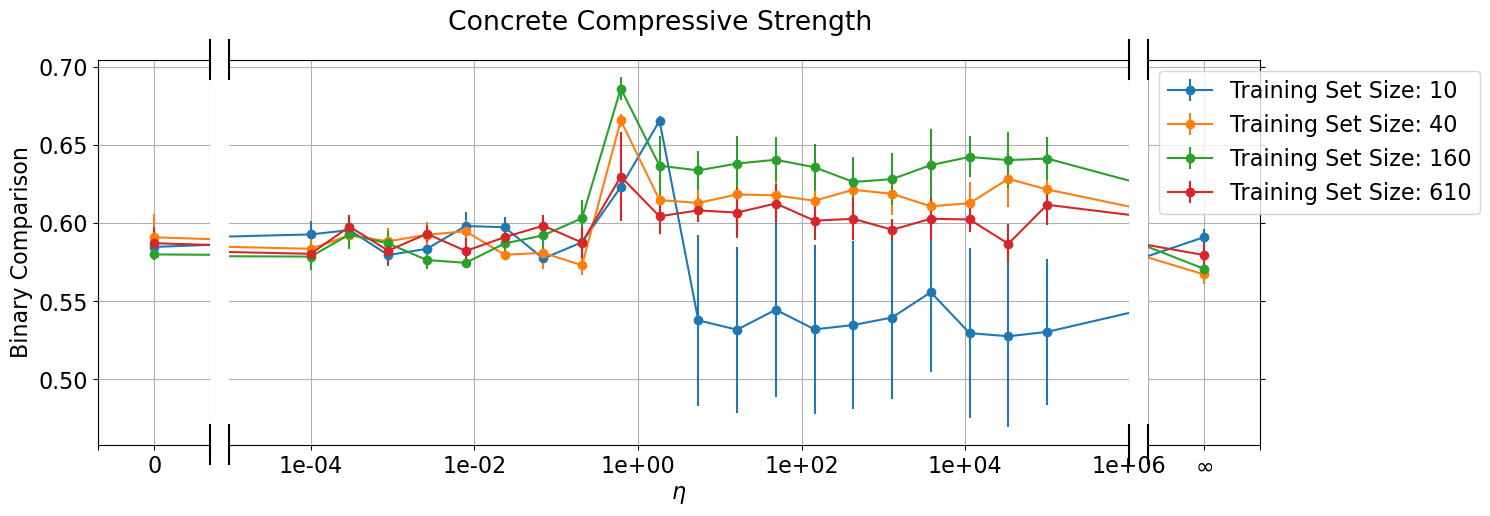

Cross-validation sses: [0.5871999999999999, 0.5803999999999999, 0.5978, 0.5824, 0.5932, 0.5822, 0.591, 0.5984, 0.5875999999999999, 0.6298, 0.6044, 0.6082, 0.6068, 0.6126, 0.6015999999999999, 0.6028, 0.5958, 0.6027999999999999, 0.6024, 0.5868, 0.6118, 0.5795999999999999]
Mean sse: 0.5975272727272727


In [79]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

print(binary_comparisons)

very_high_number = 10  # Replace this with an appropriate value for infinity
very_low_number = -10  # Replace this with an appropriate value for 0

# Function to format the tick labels
def sci_notation(tick_val, pos):
    if tick_val == very_low_number:
        return r''
    elif tick_val == very_high_number:
        return r''
    else:
        return f"{10**tick_val:.0e}"
def inf_zero_formatter(tick_val, pos):
    if tick_val == very_low_number:
        return r'$0$'
    elif tick_val == very_high_number:
        return r'$\infty$'
    else:
        return f''

# Create a loop that iterates over datasets
for p_index, dataset in enumerate(uci_datasets):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 5), gridspec_kw={'width_ratios': [.1, .8, .1]})
    fig.suptitle(f'Concrete Compressive Strength')
    plt.subplots_adjust(wspace=0.05)


    # Loop over all_results and print a scatter plot with lambda (1/(eta ** 4)) on the x-axis and the mean binary_comparisons on the y-axis for each training set size
    for training_set_value in training_set_values:
        etas = list(binary_comparisons[training_set_value].keys())
        binary_comparison_means = [np.mean(binary_comparisons[training_set_value][eta]) for eta in etas]
        binary_comparison_se = [np.std(binary_comparisons[training_set_value][eta]) / np.sqrt(len(binary_comparisons[training_set_value][eta])) for eta in etas]

        print('Graphed Values')
        print(f"Training Set Size: {training_set_value}")
        print(binary_comparison_means)
        print(binary_comparison_se)

        # Separate etas and their corresponding means and errors
        normal_etas = [eta for eta in etas if eta != 0 and eta != np.inf]
        log_normal_etas = np.log10(normal_etas)
        normal_means = [binary_comparison_means[i] for i, eta in enumerate(etas) if eta != 0 and eta != np.inf]
        normal_se = [binary_comparison_se[i] for i, eta in enumerate(etas) if eta != 0 and eta != np.inf]

        # Insert eta=0 and eta=np.inf into the lists with their positions
        if 0 in etas:
            zero_idx = etas.index(0)
            log_normal_etas = np.insert(log_normal_etas, 0, very_low_number)
            normal_means.insert(0, binary_comparison_means[zero_idx])
            normal_se.insert(0, binary_comparison_se[zero_idx])
        if np.inf in etas:
            inf_idx = etas.index(np.inf)
            log_normal_etas = np.append(log_normal_etas, very_high_number)
            normal_means.append(binary_comparison_means[inf_idx])
            normal_se.append(binary_comparison_se[inf_idx])

        # Plot the results for normal etas including eta=0 and eta=inf
        ax1.errorbar(log_normal_etas, normal_means, yerr=normal_se, fmt='o-', label=f"Training Set Size: {training_set_value}")
        ax2.errorbar(log_normal_etas, normal_means, yerr=normal_se, fmt='o-', label=f"Training Set Size: {training_set_value}")
        ax3.errorbar(log_normal_etas, normal_means, yerr=normal_se, fmt='o-', label=f"Training Set Size: {training_set_value}")

    # Set axis limits and labels
    ax1.set_xlim(left=very_low_number-1, right=very_low_number+1)  # Adjust as needed to create space around 0
    ax2.set_xlim(left=log_normal_etas[1]-1, right=log_normal_etas[-2]+1)  # Adjust as needed to create space around infinity
    ax3.set_xlim(left=very_high_number-1, right=very_high_number+1)  # Adjust as needed to create space around infinity
    ax2.set_xlabel(r'$\eta$')
    ax1.set_ylabel('Binary Comparison')
    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True)
    ax3.legend()
    
    # Use the custom formatter for the x-axis
    ax1.xaxis.set_major_formatter(FuncFormatter(inf_zero_formatter))
    ax2.xaxis.set_major_formatter(FuncFormatter(sci_notation))
    ax3.xaxis.set_major_formatter(FuncFormatter(inf_zero_formatter))

    # Hide the right spines of ax1 and the left spines of ax2
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax1.yaxis.tick_left()
    ax2.tick_params(left = False) 
    ax3.yaxis.tick_right()

    
    # Draw small vertical lines to indicate the break
    line_length = 0.05  # Length of the vertical lines

    # Top and bottom lines at the right edge of ax1
    ax1.plot([1, 1], [1 - line_length, 1 + line_length], transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot([1, 1], [0 - line_length, line_length], transform=ax1.transAxes, color='k', clip_on=False)

    # Top and bottom lines at the left edge of ax2
    ax2.plot([0, 0], [1 - line_length, 1 + line_length], transform=ax2.transAxes, color='k', clip_on=False)
    ax2.plot([0, 0], [0 - line_length, line_length], transform=ax2.transAxes, color='k', clip_on=False)

    # Top and bottom lines at the right edge of ax2
    ax2.plot([1, 1], [1 - line_length, 1 + line_length], transform=ax2.transAxes, color='k', clip_on=False)
    ax2.plot([1, 1], [0 - line_length, line_length], transform=ax2.transAxes, color='k', clip_on=False)

    # Top and bottom lines at the left edge of ax3
    ax3.plot([0, 0], [1 - line_length, 1 + line_length], transform=ax3.transAxes, color='k', clip_on=False)
    ax3.plot([0, 0], [0 - line_length, line_length], transform=ax3.transAxes, color='k', clip_on=False)

    plt.show()

    print("Cross-validation sses:", binary_comparison_means)
    print("Mean sse:", np.mean(binary_comparison_means))